In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from utils import load_rnacompete_data
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set seed for reproducibility
utils.configure_seed(42)

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### LSTM (Long Short-Term Memory) model - Bidiretional

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.layer_dim = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        
        # input_dim deve ser 4 (A,C,G,U) pois os dados são One-Hot
        self.lstm = nn.LSTM(input_dim,
                            hidden_dim//2 if bidirectional else hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True) # If set to True, input/output tensors are provided as (batch, seq_len, features) instead of (seq_len, batch, features)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (Batch, Length, Channels)
        output, (hidden, cell) = self.lstm(x)

        if self.bidirectional:
            # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:]     # take the last hidden layer
        
        hidden = self.dropout(hidden)   # aplica dropout
                
        return self.fc(hidden)

### CNN 1D model - o filtro move-se numa única direção (sequência)

In [4]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(CNN, self).__init__()
        self.num_layers = num_layers
        
        # define convolution and linear layers
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=10, padding='same') # sequência de input é (Batch, 4, 41) após permute

        if num_layers > 1:
            self.conv2 = nn.Conv1d(hidden_dim, 2 * hidden_dim, kernel_size=5, padding='same')
            conv_out_dim = hidden_dim * 2
        else:
            conv_out_dim = hidden_dim
       
        # Global Max Pooling (reduz a sequência inteira a um vetor de características)
        self.global_pool = nn.AdaptiveMaxPool1d(output_size=1)
        
        self.activation = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(conv_out_dim, output_dim)

    def forward(self, x):
        # Input: [Batch, Length, Channels] -> Permute para [Batch, Channels, Length]
        x = x.permute(0, 2, 1)

        x = self.activation(self.conv1(x))
        x = self.dropout(x)
        
        if self.num_layers > 1:
            x = self.activation(self.conv2(x))
            x = self.dropout(x)
        
        # Output: [Batch, Channels, Length] -> Global Pool -> [Batch, Channels, 1]
        x = self.global_pool(x).squeeze(-1)  # obter o output por sequência, não por nucleótido
        x = self.dropout(x)
        
        x = self.fc1(x)
        
        return x

#### Train and Evaluate the models

In [5]:
def train(model, train_dataloader, optimizer, criterion):

    epoch_loss = 0

    model.train()

    for batch in tqdm(train_dataloader):
        # Unpack the batch: (Sequences, Intensities, ValidityMasks)
        x, y, mask = batch

        # x shape:    (Batch, 41, 4)  <- One-Hot Encoded Sequence
        # y shape:    (Batch, 1)      <- Normalized Binding Intensity
        # mask shape: (Batch, 1)      <- 1.0 if valid, 0.0 if NaN

        optimizer.zero_grad()
        
        # forward pass
        predictions = model(x)

        # Calculate Loss - use the mask to zero out invalid data points
        loss = criterion(predictions, y, mask)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

In [6]:
def evaluate(model, eval_dataloader, criterion):

    epoch_loss = 0
    all_preds = []
    all_targets = []
    all_masks = []

    model.eval()

    with torch.no_grad():

        for batch in tqdm(eval_dataloader):
            # Unpack the batch: (Sequences, Intensities, ValidityMasks)
            x, y, mask = batch

            # x shape:    (Batch, 41, 4)  <- One-Hot Encoded Sequence
            # y shape:    (Batch, 1)      <- Normalized Binding Intensity
            # mask shape: (Batch, 1)      <- 1.0 if valid, 0.0 if NaN

            # forward pass
            predictions = model(x)

            # Calculate Loss - use the mask to zero out invalid data points
            loss = criterion(predictions, y, mask)
            epoch_loss += loss.item()

            # Guardar tensores
            all_preds.append(predictions.cpu())
            all_targets.append(y.cpu())
            all_masks.append(mask.cpu())
    
    # Concatenar tudo num único tensor grande
    full_preds = torch.cat(all_preds)
    full_targets = torch.cat(all_targets)
    full_masks = torch.cat(all_masks)

    # Calcular Spearman Correlation 
    spearman_corr = utils.masked_spearman_correlation(full_preds, full_targets, full_masks)

    return epoch_loss / len(eval_dataloader), spearman_corr

#### Load the data

In [7]:
# Load Data for a specific protein (e.g., 'RBFOX1', 'PTB', 'A1CF') -> Neste projeto usamos RBFOX1
# This returns a PyTorch TensorDataset ready for training
train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
val_dataset   = load_rnacompete_data(protein_name='RBFOX1', split='val')
test_dataset  = load_rnacompete_data(protein_name='RBFOX1', split='test')

# Wrap in a standard PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 30

Found cached data for RBFOX1 (train). Loading from data\RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from data\RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from data\RBFOX1_test_data.pt...


In [8]:
import itertools

hyper_params_LSTM = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0005],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_LSTM.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_LSTM = -1
best_config_LSTM = None
best_train_losses_LSTM = []
best_valid_losses_LSTM = []

for config in combinations:
    print(f"\n Testing config: {config}")
    
    model_LSTM = LSTM(input_dim=4,
                    hidden_dim=config['width'], 
                    output_dim=1, 
                    n_layers=config['num_layers'],
                    bidirectional=True, 
                    dropout=config['dropout'], 
                    )
    
    optimizer = optim.Adam(model_LSTM.parameters(), lr=config['lr_rate'], weight_decay=1e-4)
    
    criterion = utils.masked_mse_loss

    # listas para guardar os resultados para os plots
    train_loss_LSTM = []
    valid_loss_LSTM = []
    valid_corrs_LSTM = []

    # LSTM training loop
    for epoch in range(num_epochs):
        train_loss = train(model_LSTM, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_LSTM, valid_loader, criterion)

        # para os plots
        train_loss_LSTM.append(train_loss)
        valid_loss_LSTM.append(valid_loss)
        valid_corrs_LSTM.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação) 
    if valid_corr > best_val_corr_LSTM:
        best_val_corr_LSTM = valid_corr
        best_config_LSTM = config
        best_train_losses_LSTM = train_loss_LSTM[:] # cópia da lista
        best_valid_losses_LSTM = valid_loss_LSTM[:] 
        # torch.save(model.state_dict(), 'best_lstm.pth')

print(f"Melhor Configuração: {best_config_LSTM} com Spearman: {best_val_corr_LSTM}")


 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 370.78it/s]


Epoch: 01
	 Train Loss: 0.9515
	 Val. Loss: 0.9199 | Val. Corr: 0.3229


100%|██████████| 377/377 [00:01<00:00, 367.57it/s]


Epoch: 02
	 Train Loss: 0.8101
	 Val. Loss: 0.6237 | Val. Corr: 0.4557


100%|██████████| 377/377 [00:01<00:00, 369.05it/s]


Epoch: 03
	 Train Loss: 0.5559
	 Val. Loss: 0.5340 | Val. Corr: 0.4980


100%|██████████| 377/377 [00:01<00:00, 375.44it/s]


Epoch: 04
	 Train Loss: 0.5162
	 Val. Loss: 0.5013 | Val. Corr: 0.5190


100%|██████████| 377/377 [00:01<00:00, 327.41it/s]


Epoch: 05
	 Train Loss: 0.5004
	 Val. Loss: 0.5039 | Val. Corr: 0.5202


100%|██████████| 377/377 [00:00<00:00, 415.41it/s]


Epoch: 06
	 Train Loss: 0.4875
	 Val. Loss: 0.5008 | Val. Corr: 0.5279


100%|██████████| 377/377 [00:00<00:00, 415.90it/s]


Epoch: 07
	 Train Loss: 0.4806
	 Val. Loss: 0.4882 | Val. Corr: 0.5290


100%|██████████| 377/377 [00:00<00:00, 410.26it/s]


Epoch: 08
	 Train Loss: 0.4750
	 Val. Loss: 0.4856 | Val. Corr: 0.5304


100%|██████████| 377/377 [00:00<00:00, 428.26it/s]


Epoch: 09
	 Train Loss: 0.4698
	 Val. Loss: 0.4959 | Val. Corr: 0.5358


100%|██████████| 377/377 [00:00<00:00, 424.72it/s]


Epoch: 10
	 Train Loss: 0.4639
	 Val. Loss: 0.4743 | Val. Corr: 0.5447


100%|██████████| 377/377 [00:00<00:00, 424.34it/s]


Epoch: 11
	 Train Loss: 0.4554
	 Val. Loss: 0.4981 | Val. Corr: 0.5413


100%|██████████| 377/377 [00:00<00:00, 421.79it/s]


Epoch: 12
	 Train Loss: 0.4484
	 Val. Loss: 0.4700 | Val. Corr: 0.5500


100%|██████████| 377/377 [00:00<00:00, 422.91it/s]


Epoch: 13
	 Train Loss: 0.4418
	 Val. Loss: 0.4750 | Val. Corr: 0.5539


100%|██████████| 377/377 [00:00<00:00, 417.77it/s]


Epoch: 14
	 Train Loss: 0.4339
	 Val. Loss: 0.4759 | Val. Corr: 0.5630


100%|██████████| 377/377 [00:00<00:00, 435.09it/s]


Epoch: 15
	 Train Loss: 0.4193
	 Val. Loss: 0.4423 | Val. Corr: 0.5670


100%|██████████| 377/377 [00:00<00:00, 395.51it/s]


Epoch: 16
	 Train Loss: 0.4091
	 Val. Loss: 0.4261 | Val. Corr: 0.5763


100%|██████████| 377/377 [00:00<00:00, 432.87it/s]


Epoch: 17
	 Train Loss: 0.3955
	 Val. Loss: 0.4102 | Val. Corr: 0.5835


100%|██████████| 377/377 [00:00<00:00, 426.80it/s]


Epoch: 18
	 Train Loss: 0.3806
	 Val. Loss: 0.3981 | Val. Corr: 0.6033


100%|██████████| 377/377 [00:00<00:00, 430.12it/s]


Epoch: 19
	 Train Loss: 0.3730
	 Val. Loss: 0.3915 | Val. Corr: 0.6030


100%|██████████| 377/377 [00:00<00:00, 398.16it/s]


Epoch: 20
	 Train Loss: 0.3652
	 Val. Loss: 0.3846 | Val. Corr: 0.6070


100%|██████████| 377/377 [00:00<00:00, 444.37it/s]


Epoch: 21
	 Train Loss: 0.3608
	 Val. Loss: 0.3871 | Val. Corr: 0.6162


100%|██████████| 377/377 [00:00<00:00, 427.05it/s]


Epoch: 22
	 Train Loss: 0.3550
	 Val. Loss: 0.3938 | Val. Corr: 0.6108


100%|██████████| 377/377 [00:00<00:00, 393.53it/s]


Epoch: 23
	 Train Loss: 0.3538
	 Val. Loss: 0.3845 | Val. Corr: 0.6214


100%|██████████| 377/377 [00:00<00:00, 411.59it/s]


Epoch: 24
	 Train Loss: 0.3493
	 Val. Loss: 0.3784 | Val. Corr: 0.6223


100%|██████████| 377/377 [00:00<00:00, 403.29it/s]


Epoch: 25
	 Train Loss: 0.3454
	 Val. Loss: 0.3780 | Val. Corr: 0.6234


100%|██████████| 377/377 [00:00<00:00, 411.41it/s]


Epoch: 26
	 Train Loss: 0.3423
	 Val. Loss: 0.3721 | Val. Corr: 0.6196


100%|██████████| 377/377 [00:00<00:00, 415.10it/s]


Epoch: 27
	 Train Loss: 0.3387
	 Val. Loss: 0.3666 | Val. Corr: 0.6271


100%|██████████| 377/377 [00:00<00:00, 418.68it/s]


Epoch: 28
	 Train Loss: 0.3364
	 Val. Loss: 0.3689 | Val. Corr: 0.6316


100%|██████████| 377/377 [00:00<00:00, 420.08it/s]


Epoch: 29
	 Train Loss: 0.3335
	 Val. Loss: 0.3779 | Val. Corr: 0.6279


100%|██████████| 377/377 [00:00<00:00, 411.64it/s]


Epoch: 30
	 Train Loss: 0.3321
	 Val. Loss: 0.3992 | Val. Corr: 0.6319

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 412.91it/s]


Epoch: 01
	 Train Loss: 0.9613
	 Val. Loss: 0.9433 | Val. Corr: 0.2906


100%|██████████| 377/377 [00:00<00:00, 418.53it/s]


Epoch: 02
	 Train Loss: 0.9336
	 Val. Loss: 0.9111 | Val. Corr: 0.3318


100%|██████████| 377/377 [00:00<00:00, 409.76it/s]


Epoch: 03
	 Train Loss: 0.8912
	 Val. Loss: 0.8385 | Val. Corr: 0.3949


100%|██████████| 377/377 [00:00<00:00, 417.07it/s]


Epoch: 04
	 Train Loss: 0.7827
	 Val. Loss: 0.6760 | Val. Corr: 0.4442


100%|██████████| 377/377 [00:00<00:00, 410.12it/s]


Epoch: 05
	 Train Loss: 0.5982
	 Val. Loss: 0.5506 | Val. Corr: 0.4827


100%|██████████| 377/377 [00:00<00:00, 416.06it/s]


Epoch: 06
	 Train Loss: 0.5374
	 Val. Loss: 0.5288 | Val. Corr: 0.5014


100%|██████████| 377/377 [00:00<00:00, 411.12it/s]


Epoch: 07
	 Train Loss: 0.5184
	 Val. Loss: 0.5118 | Val. Corr: 0.5125


100%|██████████| 377/377 [00:00<00:00, 398.38it/s]


Epoch: 08
	 Train Loss: 0.5078
	 Val. Loss: 0.5064 | Val. Corr: 0.5181


100%|██████████| 377/377 [00:00<00:00, 405.15it/s]


Epoch: 09
	 Train Loss: 0.5010
	 Val. Loss: 0.5046 | Val. Corr: 0.5180


100%|██████████| 377/377 [00:00<00:00, 395.29it/s]


Epoch: 10
	 Train Loss: 0.4922
	 Val. Loss: 0.4901 | Val. Corr: 0.5287


100%|██████████| 377/377 [00:00<00:00, 412.49it/s]


Epoch: 11
	 Train Loss: 0.4846
	 Val. Loss: 0.5121 | Val. Corr: 0.5324


100%|██████████| 377/377 [00:00<00:00, 402.07it/s]


Epoch: 12
	 Train Loss: 0.4803
	 Val. Loss: 0.4994 | Val. Corr: 0.5414


100%|██████████| 377/377 [00:00<00:00, 414.78it/s]


Epoch: 13
	 Train Loss: 0.4769
	 Val. Loss: 0.4760 | Val. Corr: 0.5412


100%|██████████| 377/377 [00:00<00:00, 411.59it/s]


Epoch: 14
	 Train Loss: 0.4707
	 Val. Loss: 0.4842 | Val. Corr: 0.5451


100%|██████████| 377/377 [00:00<00:00, 416.41it/s]


Epoch: 15
	 Train Loss: 0.4669
	 Val. Loss: 0.4686 | Val. Corr: 0.5498


100%|██████████| 377/377 [00:00<00:00, 407.44it/s]


Epoch: 16
	 Train Loss: 0.4617
	 Val. Loss: 0.4729 | Val. Corr: 0.5538


100%|██████████| 377/377 [00:00<00:00, 407.58it/s]


Epoch: 17
	 Train Loss: 0.4567
	 Val. Loss: 0.4649 | Val. Corr: 0.5608


100%|██████████| 377/377 [00:00<00:00, 397.87it/s]


Epoch: 18
	 Train Loss: 0.4516
	 Val. Loss: 0.4633 | Val. Corr: 0.5611


100%|██████████| 377/377 [00:00<00:00, 411.17it/s]


Epoch: 19
	 Train Loss: 0.4474
	 Val. Loss: 0.4697 | Val. Corr: 0.5598


100%|██████████| 377/377 [00:00<00:00, 412.38it/s]


Epoch: 20
	 Train Loss: 0.4438
	 Val. Loss: 0.4587 | Val. Corr: 0.5632


100%|██████████| 377/377 [00:00<00:00, 393.02it/s]


Epoch: 21
	 Train Loss: 0.4392
	 Val. Loss: 0.4466 | Val. Corr: 0.5710


100%|██████████| 377/377 [00:00<00:00, 419.93it/s]


Epoch: 22
	 Train Loss: 0.4325
	 Val. Loss: 0.4500 | Val. Corr: 0.5719


100%|██████████| 377/377 [00:00<00:00, 406.37it/s]


Epoch: 23
	 Train Loss: 0.4268
	 Val. Loss: 0.4360 | Val. Corr: 0.5789


100%|██████████| 377/377 [00:00<00:00, 413.83it/s]


Epoch: 24
	 Train Loss: 0.4220
	 Val. Loss: 0.4476 | Val. Corr: 0.5759


100%|██████████| 377/377 [00:00<00:00, 407.08it/s]


Epoch: 25
	 Train Loss: 0.4171
	 Val. Loss: 0.4391 | Val. Corr: 0.5743


100%|██████████| 377/377 [00:00<00:00, 410.56it/s]


Epoch: 26
	 Train Loss: 0.4114
	 Val. Loss: 0.4411 | Val. Corr: 0.5833


100%|██████████| 377/377 [00:00<00:00, 415.03it/s]


Epoch: 27
	 Train Loss: 0.4081
	 Val. Loss: 0.4165 | Val. Corr: 0.5866


100%|██████████| 377/377 [00:00<00:00, 414.86it/s]


Epoch: 28
	 Train Loss: 0.3989
	 Val. Loss: 0.4363 | Val. Corr: 0.5792


100%|██████████| 377/377 [00:00<00:00, 405.69it/s]


Epoch: 29
	 Train Loss: 0.3902
	 Val. Loss: 0.4214 | Val. Corr: 0.5761


100%|██████████| 377/377 [00:00<00:00, 392.23it/s]


Epoch: 30
	 Train Loss: 0.3866
	 Val. Loss: 0.3998 | Val. Corr: 0.5982

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 417.16it/s]


Epoch: 01
	 Train Loss: 0.9583
	 Val. Loss: 0.9308 | Val. Corr: 0.3101


100%|██████████| 377/377 [00:00<00:00, 410.17it/s]


Epoch: 02
	 Train Loss: 0.8822
	 Val. Loss: 0.7570 | Val. Corr: 0.4156


100%|██████████| 377/377 [00:00<00:00, 407.55it/s]


Epoch: 03
	 Train Loss: 0.6169
	 Val. Loss: 0.5785 | Val. Corr: 0.4808


100%|██████████| 377/377 [00:00<00:00, 412.50it/s]


Epoch: 04
	 Train Loss: 0.5379
	 Val. Loss: 0.5612 | Val. Corr: 0.5073


100%|██████████| 377/377 [00:00<00:00, 403.16it/s]


Epoch: 05
	 Train Loss: 0.5211
	 Val. Loss: 0.5100 | Val. Corr: 0.5140


100%|██████████| 377/377 [00:00<00:00, 401.53it/s]


Epoch: 06
	 Train Loss: 0.5115
	 Val. Loss: 0.4948 | Val. Corr: 0.5238


100%|██████████| 377/377 [00:00<00:00, 413.42it/s]


Epoch: 07
	 Train Loss: 0.5044
	 Val. Loss: 0.5132 | Val. Corr: 0.5257


100%|██████████| 377/377 [00:00<00:00, 402.43it/s]


Epoch: 08
	 Train Loss: 0.4971
	 Val. Loss: 0.4858 | Val. Corr: 0.5287


100%|██████████| 377/377 [00:00<00:00, 410.58it/s]


Epoch: 09
	 Train Loss: 0.4839
	 Val. Loss: 0.4812 | Val. Corr: 0.5274


100%|██████████| 377/377 [00:00<00:00, 410.01it/s]


Epoch: 10
	 Train Loss: 0.4810
	 Val. Loss: 0.4832 | Val. Corr: 0.5328


100%|██████████| 377/377 [00:00<00:00, 418.71it/s]


Epoch: 11
	 Train Loss: 0.4724
	 Val. Loss: 0.4616 | Val. Corr: 0.5381


100%|██████████| 377/377 [00:00<00:00, 410.71it/s]


Epoch: 12
	 Train Loss: 0.4671
	 Val. Loss: 0.4757 | Val. Corr: 0.5331


100%|██████████| 377/377 [00:00<00:00, 411.44it/s]


Epoch: 13
	 Train Loss: 0.4616
	 Val. Loss: 0.4677 | Val. Corr: 0.5384


100%|██████████| 377/377 [00:00<00:00, 398.47it/s]


Epoch: 14
	 Train Loss: 0.4510
	 Val. Loss: 0.4514 | Val. Corr: 0.5435


100%|██████████| 377/377 [00:00<00:00, 410.15it/s]


Epoch: 15
	 Train Loss: 0.4433
	 Val. Loss: 0.4378 | Val. Corr: 0.5468


100%|██████████| 377/377 [00:00<00:00, 411.06it/s]


Epoch: 16
	 Train Loss: 0.4371
	 Val. Loss: 0.4352 | Val. Corr: 0.5477


100%|██████████| 377/377 [00:00<00:00, 407.52it/s]


Epoch: 17
	 Train Loss: 0.4301
	 Val. Loss: 0.4231 | Val. Corr: 0.5539


100%|██████████| 377/377 [00:00<00:00, 408.50it/s]


Epoch: 18
	 Train Loss: 0.4191
	 Val. Loss: 0.4198 | Val. Corr: 0.5597


100%|██████████| 377/377 [00:00<00:00, 413.27it/s]


Epoch: 19
	 Train Loss: 0.4122
	 Val. Loss: 0.4356 | Val. Corr: 0.5660


100%|██████████| 377/377 [00:01<00:00, 365.99it/s]


Epoch: 20
	 Train Loss: 0.4064
	 Val. Loss: 0.4262 | Val. Corr: 0.5740


100%|██████████| 377/377 [00:00<00:00, 403.74it/s]


Epoch: 21
	 Train Loss: 0.4016
	 Val. Loss: 0.4170 | Val. Corr: 0.5871


100%|██████████| 377/377 [00:00<00:00, 408.49it/s]


Epoch: 22
	 Train Loss: 0.3956
	 Val. Loss: 0.4090 | Val. Corr: 0.5903


100%|██████████| 377/377 [00:00<00:00, 406.75it/s]


Epoch: 23
	 Train Loss: 0.3932
	 Val. Loss: 0.4350 | Val. Corr: 0.5898


100%|██████████| 377/377 [00:00<00:00, 411.32it/s]


Epoch: 24
	 Train Loss: 0.3878
	 Val. Loss: 0.4016 | Val. Corr: 0.6002


100%|██████████| 377/377 [00:00<00:00, 405.81it/s]


Epoch: 25
	 Train Loss: 0.3805
	 Val. Loss: 0.3900 | Val. Corr: 0.6044


100%|██████████| 377/377 [00:00<00:00, 392.69it/s]


Epoch: 26
	 Train Loss: 0.3804
	 Val. Loss: 0.3941 | Val. Corr: 0.6038


100%|██████████| 377/377 [00:00<00:00, 403.58it/s]


Epoch: 27
	 Train Loss: 0.3751
	 Val. Loss: 0.3954 | Val. Corr: 0.6131


100%|██████████| 377/377 [00:00<00:00, 413.32it/s]


Epoch: 28
	 Train Loss: 0.3736
	 Val. Loss: 0.3888 | Val. Corr: 0.6132


100%|██████████| 377/377 [00:00<00:00, 411.40it/s]


Epoch: 29
	 Train Loss: 0.3719
	 Val. Loss: 0.3897 | Val. Corr: 0.6140


100%|██████████| 377/377 [00:00<00:00, 404.32it/s]


Epoch: 30
	 Train Loss: 0.3654
	 Val. Loss: 0.3840 | Val. Corr: 0.6146

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 416.18it/s]


Epoch: 01
	 Train Loss: 0.9636
	 Val. Loss: 0.9436 | Val. Corr: 0.2956


100%|██████████| 377/377 [00:00<00:00, 402.96it/s]


Epoch: 02
	 Train Loss: 0.9304
	 Val. Loss: 0.8946 | Val. Corr: 0.3616


100%|██████████| 377/377 [00:00<00:00, 404.90it/s]


Epoch: 03
	 Train Loss: 0.8438
	 Val. Loss: 0.7573 | Val. Corr: 0.4319


100%|██████████| 377/377 [00:00<00:00, 398.72it/s]


Epoch: 04
	 Train Loss: 0.6811
	 Val. Loss: 0.6099 | Val. Corr: 0.4598


100%|██████████| 377/377 [00:00<00:00, 403.41it/s]


Epoch: 05
	 Train Loss: 0.5738
	 Val. Loss: 0.5496 | Val. Corr: 0.4827


100%|██████████| 377/377 [00:00<00:00, 397.39it/s]


Epoch: 06
	 Train Loss: 0.5457
	 Val. Loss: 0.5305 | Val. Corr: 0.5057


100%|██████████| 377/377 [00:00<00:00, 413.88it/s]


Epoch: 07
	 Train Loss: 0.5315
	 Val. Loss: 0.5129 | Val. Corr: 0.5155


100%|██████████| 377/377 [00:00<00:00, 383.15it/s]


Epoch: 08
	 Train Loss: 0.5190
	 Val. Loss: 0.5170 | Val. Corr: 0.5200


100%|██████████| 377/377 [00:00<00:00, 401.57it/s]


Epoch: 09
	 Train Loss: 0.5116
	 Val. Loss: 0.5004 | Val. Corr: 0.5208


100%|██████████| 377/377 [00:00<00:00, 416.55it/s]


Epoch: 10
	 Train Loss: 0.5049
	 Val. Loss: 0.5033 | Val. Corr: 0.5309


100%|██████████| 377/377 [00:00<00:00, 414.33it/s]


Epoch: 11
	 Train Loss: 0.4964
	 Val. Loss: 0.4858 | Val. Corr: 0.5290


100%|██████████| 377/377 [00:00<00:00, 405.45it/s]


Epoch: 12
	 Train Loss: 0.4933
	 Val. Loss: 0.4824 | Val. Corr: 0.5312


100%|██████████| 377/377 [00:00<00:00, 406.36it/s]


Epoch: 13
	 Train Loss: 0.4874
	 Val. Loss: 0.4816 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 415.75it/s]


Epoch: 14
	 Train Loss: 0.4803
	 Val. Loss: 0.4767 | Val. Corr: 0.5334


100%|██████████| 377/377 [00:00<00:00, 390.22it/s]


Epoch: 15
	 Train Loss: 0.4781
	 Val. Loss: 0.4999 | Val. Corr: 0.5385


100%|██████████| 377/377 [00:00<00:00, 394.37it/s]


Epoch: 16
	 Train Loss: 0.4758
	 Val. Loss: 0.4683 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 413.69it/s]


Epoch: 17
	 Train Loss: 0.4708
	 Val. Loss: 0.4778 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 405.93it/s]


Epoch: 18
	 Train Loss: 0.4665
	 Val. Loss: 0.5040 | Val. Corr: 0.5504


100%|██████████| 377/377 [00:00<00:00, 405.22it/s]


Epoch: 19
	 Train Loss: 0.4575
	 Val. Loss: 0.4575 | Val. Corr: 0.5564


100%|██████████| 377/377 [00:00<00:00, 413.14it/s]


Epoch: 20
	 Train Loss: 0.4544
	 Val. Loss: 0.4503 | Val. Corr: 0.5608


100%|██████████| 377/377 [00:00<00:00, 409.58it/s]


Epoch: 21
	 Train Loss: 0.4475
	 Val. Loss: 0.4502 | Val. Corr: 0.5516


100%|██████████| 377/377 [00:00<00:00, 401.04it/s]


Epoch: 22
	 Train Loss: 0.4406
	 Val. Loss: 0.4683 | Val. Corr: 0.5681


100%|██████████| 377/377 [00:00<00:00, 407.97it/s]


Epoch: 23
	 Train Loss: 0.4387
	 Val. Loss: 0.4412 | Val. Corr: 0.5703


100%|██████████| 377/377 [00:00<00:00, 410.57it/s]


Epoch: 24
	 Train Loss: 0.4334
	 Val. Loss: 0.4392 | Val. Corr: 0.5623


100%|██████████| 377/377 [00:00<00:00, 417.70it/s]


Epoch: 25
	 Train Loss: 0.4310
	 Val. Loss: 0.4333 | Val. Corr: 0.5691


100%|██████████| 377/377 [00:00<00:00, 405.54it/s]


Epoch: 26
	 Train Loss: 0.4265
	 Val. Loss: 0.4262 | Val. Corr: 0.5728


100%|██████████| 377/377 [00:00<00:00, 411.24it/s]


Epoch: 27
	 Train Loss: 0.4220
	 Val. Loss: 0.4323 | Val. Corr: 0.5652


100%|██████████| 377/377 [00:00<00:00, 410.25it/s]


Epoch: 28
	 Train Loss: 0.4173
	 Val. Loss: 0.4660 | Val. Corr: 0.5755


100%|██████████| 377/377 [00:00<00:00, 409.38it/s]


Epoch: 29
	 Train Loss: 0.4141
	 Val. Loss: 0.4315 | Val. Corr: 0.5758


100%|██████████| 377/377 [00:00<00:00, 412.38it/s]


Epoch: 30
	 Train Loss: 0.4096
	 Val. Loss: 0.4151 | Val. Corr: 0.5795

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 270.47it/s]


Epoch: 01
	 Train Loss: 0.9524
	 Val. Loss: 0.9207 | Val. Corr: 0.3301


100%|██████████| 377/377 [00:01<00:00, 274.97it/s]


Epoch: 02
	 Train Loss: 0.7105
	 Val. Loss: 0.5394 | Val. Corr: 0.4913


100%|██████████| 377/377 [00:01<00:00, 260.75it/s]


Epoch: 03
	 Train Loss: 0.5186
	 Val. Loss: 0.5143 | Val. Corr: 0.5164


100%|██████████| 377/377 [00:01<00:00, 271.24it/s]


Epoch: 04
	 Train Loss: 0.4958
	 Val. Loss: 0.4918 | Val. Corr: 0.5250


100%|██████████| 377/377 [00:01<00:00, 271.38it/s]


Epoch: 05
	 Train Loss: 0.4828
	 Val. Loss: 0.4872 | Val. Corr: 0.5283


100%|██████████| 377/377 [00:01<00:00, 271.31it/s]


Epoch: 06
	 Train Loss: 0.4707
	 Val. Loss: 0.4814 | Val. Corr: 0.5413


100%|██████████| 377/377 [00:01<00:00, 269.98it/s]


Epoch: 07
	 Train Loss: 0.4575
	 Val. Loss: 0.4602 | Val. Corr: 0.5401


100%|██████████| 377/377 [00:01<00:00, 271.06it/s]


Epoch: 08
	 Train Loss: 0.4356
	 Val. Loss: 0.4351 | Val. Corr: 0.5495


100%|██████████| 377/377 [00:01<00:00, 271.78it/s]


Epoch: 09
	 Train Loss: 0.4165
	 Val. Loss: 0.4300 | Val. Corr: 0.5636


100%|██████████| 377/377 [00:01<00:00, 273.54it/s]


Epoch: 10
	 Train Loss: 0.3943
	 Val. Loss: 0.4203 | Val. Corr: 0.5906


100%|██████████| 377/377 [00:01<00:00, 270.22it/s]


Epoch: 11
	 Train Loss: 0.3769
	 Val. Loss: 0.4177 | Val. Corr: 0.6063


100%|██████████| 377/377 [00:01<00:00, 265.47it/s]


Epoch: 12
	 Train Loss: 0.3680
	 Val. Loss: 0.4037 | Val. Corr: 0.6068


100%|██████████| 377/377 [00:01<00:00, 265.39it/s]


Epoch: 13
	 Train Loss: 0.3591
	 Val. Loss: 0.3806 | Val. Corr: 0.6162


100%|██████████| 377/377 [00:01<00:00, 265.82it/s]


Epoch: 14
	 Train Loss: 0.3563
	 Val. Loss: 0.3865 | Val. Corr: 0.6229


100%|██████████| 377/377 [00:01<00:00, 270.00it/s]


Epoch: 15
	 Train Loss: 0.3480
	 Val. Loss: 0.3664 | Val. Corr: 0.6262


100%|██████████| 377/377 [00:01<00:00, 267.14it/s]


Epoch: 16
	 Train Loss: 0.3417
	 Val. Loss: 0.3718 | Val. Corr: 0.6278


100%|██████████| 377/377 [00:01<00:00, 261.52it/s]


Epoch: 17
	 Train Loss: 0.3362
	 Val. Loss: 0.3796 | Val. Corr: 0.6289


100%|██████████| 377/377 [00:01<00:00, 270.40it/s]


Epoch: 18
	 Train Loss: 0.3317
	 Val. Loss: 0.3713 | Val. Corr: 0.6371


100%|██████████| 377/377 [00:01<00:00, 276.24it/s]


Epoch: 19
	 Train Loss: 0.3309
	 Val. Loss: 0.3646 | Val. Corr: 0.6397


100%|██████████| 377/377 [00:01<00:00, 273.59it/s]


Epoch: 20
	 Train Loss: 0.3235
	 Val. Loss: 0.4039 | Val. Corr: 0.6317


100%|██████████| 377/377 [00:01<00:00, 275.41it/s]


Epoch: 21
	 Train Loss: 0.3191
	 Val. Loss: 0.3734 | Val. Corr: 0.6346


100%|██████████| 377/377 [00:01<00:00, 276.36it/s]


Epoch: 22
	 Train Loss: 0.3164
	 Val. Loss: 0.3560 | Val. Corr: 0.6456


100%|██████████| 377/377 [00:01<00:00, 273.23it/s]


Epoch: 23
	 Train Loss: 0.3144
	 Val. Loss: 0.3500 | Val. Corr: 0.6457


100%|██████████| 377/377 [00:01<00:00, 237.92it/s]


Epoch: 24
	 Train Loss: 0.3104
	 Val. Loss: 0.3540 | Val. Corr: 0.6450


100%|██████████| 377/377 [00:01<00:00, 277.51it/s]


Epoch: 25
	 Train Loss: 0.3074
	 Val. Loss: 0.3532 | Val. Corr: 0.6477


100%|██████████| 377/377 [00:01<00:00, 276.64it/s]


Epoch: 26
	 Train Loss: 0.3028
	 Val. Loss: 0.3616 | Val. Corr: 0.6475


100%|██████████| 377/377 [00:01<00:00, 267.55it/s]


Epoch: 27
	 Train Loss: 0.3009
	 Val. Loss: 0.3500 | Val. Corr: 0.6468


100%|██████████| 377/377 [00:01<00:00, 278.22it/s]


Epoch: 28
	 Train Loss: 0.2975
	 Val. Loss: 0.3423 | Val. Corr: 0.6527


100%|██████████| 377/377 [00:01<00:00, 276.82it/s]


Epoch: 29
	 Train Loss: 0.2969
	 Val. Loss: 0.3408 | Val. Corr: 0.6541


100%|██████████| 377/377 [00:01<00:00, 271.06it/s]


Epoch: 30
	 Train Loss: 0.2919
	 Val. Loss: 0.3508 | Val. Corr: 0.6525

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 271.61it/s]


Epoch: 01
	 Train Loss: 0.9598
	 Val. Loss: 0.9428 | Val. Corr: 0.2834


100%|██████████| 377/377 [00:01<00:00, 277.43it/s]


Epoch: 02
	 Train Loss: 0.9355
	 Val. Loss: 0.9113 | Val. Corr: 0.3330


100%|██████████| 377/377 [00:01<00:00, 278.11it/s]


Epoch: 03
	 Train Loss: 0.8337
	 Val. Loss: 0.6345 | Val. Corr: 0.4386


100%|██████████| 377/377 [00:01<00:00, 273.81it/s]


Epoch: 04
	 Train Loss: 0.5640
	 Val. Loss: 0.5346 | Val. Corr: 0.5016


100%|██████████| 377/377 [00:01<00:00, 268.24it/s]


Epoch: 05
	 Train Loss: 0.5206
	 Val. Loss: 0.5122 | Val. Corr: 0.5116


100%|██████████| 377/377 [00:01<00:00, 260.16it/s]


Epoch: 06
	 Train Loss: 0.5068
	 Val. Loss: 0.5046 | Val. Corr: 0.5181


100%|██████████| 377/377 [00:01<00:00, 274.15it/s]


Epoch: 07
	 Train Loss: 0.4955
	 Val. Loss: 0.4957 | Val. Corr: 0.5199


100%|██████████| 377/377 [00:01<00:00, 266.19it/s]


Epoch: 08
	 Train Loss: 0.4887
	 Val. Loss: 0.4975 | Val. Corr: 0.5205


100%|██████████| 377/377 [00:01<00:00, 268.72it/s]


Epoch: 09
	 Train Loss: 0.4811
	 Val. Loss: 0.4967 | Val. Corr: 0.5307


100%|██████████| 377/377 [00:01<00:00, 273.76it/s]


Epoch: 10
	 Train Loss: 0.4770
	 Val. Loss: 0.5031 | Val. Corr: 0.5340


100%|██████████| 377/377 [00:01<00:00, 272.93it/s]


Epoch: 11
	 Train Loss: 0.4723
	 Val. Loss: 0.4844 | Val. Corr: 0.5394


100%|██████████| 377/377 [00:01<00:00, 270.89it/s]


Epoch: 12
	 Train Loss: 0.4646
	 Val. Loss: 0.4745 | Val. Corr: 0.5424


100%|██████████| 377/377 [00:01<00:00, 271.95it/s]


Epoch: 13
	 Train Loss: 0.4554
	 Val. Loss: 0.4667 | Val. Corr: 0.5524


100%|██████████| 377/377 [00:01<00:00, 262.05it/s]


Epoch: 14
	 Train Loss: 0.4500
	 Val. Loss: 0.4589 | Val. Corr: 0.5493


100%|██████████| 377/377 [00:01<00:00, 272.12it/s]


Epoch: 15
	 Train Loss: 0.4413
	 Val. Loss: 0.4509 | Val. Corr: 0.5587


100%|██████████| 377/377 [00:01<00:00, 274.58it/s]


Epoch: 16
	 Train Loss: 0.4346
	 Val. Loss: 0.4771 | Val. Corr: 0.5592


100%|██████████| 377/377 [00:01<00:00, 270.48it/s]


Epoch: 17
	 Train Loss: 0.4229
	 Val. Loss: 0.4372 | Val. Corr: 0.5644


100%|██████████| 377/377 [00:01<00:00, 272.30it/s]


Epoch: 18
	 Train Loss: 0.4049
	 Val. Loss: 0.4191 | Val. Corr: 0.5870


100%|██████████| 377/377 [00:01<00:00, 267.54it/s]


Epoch: 19
	 Train Loss: 0.3893
	 Val. Loss: 0.4101 | Val. Corr: 0.5875


100%|██████████| 377/377 [00:01<00:00, 272.19it/s]


Epoch: 20
	 Train Loss: 0.3787
	 Val. Loss: 0.3908 | Val. Corr: 0.6064


100%|██████████| 377/377 [00:01<00:00, 271.77it/s]


Epoch: 21
	 Train Loss: 0.3695
	 Val. Loss: 0.4114 | Val. Corr: 0.6000


100%|██████████| 377/377 [00:01<00:00, 272.66it/s]


Epoch: 22
	 Train Loss: 0.3646
	 Val. Loss: 0.3873 | Val. Corr: 0.6072


100%|██████████| 377/377 [00:01<00:00, 273.90it/s]


Epoch: 23
	 Train Loss: 0.3597
	 Val. Loss: 0.3887 | Val. Corr: 0.6112


100%|██████████| 377/377 [00:01<00:00, 269.11it/s]


Epoch: 24
	 Train Loss: 0.3569
	 Val. Loss: 0.3937 | Val. Corr: 0.6157


100%|██████████| 377/377 [00:01<00:00, 271.32it/s]


Epoch: 25
	 Train Loss: 0.3514
	 Val. Loss: 0.3904 | Val. Corr: 0.6165


100%|██████████| 377/377 [00:01<00:00, 276.41it/s]


Epoch: 26
	 Train Loss: 0.3476
	 Val. Loss: 0.3728 | Val. Corr: 0.6183


100%|██████████| 377/377 [00:01<00:00, 268.77it/s]


Epoch: 27
	 Train Loss: 0.3437
	 Val. Loss: 0.3720 | Val. Corr: 0.6225


100%|██████████| 377/377 [00:01<00:00, 271.59it/s]


Epoch: 28
	 Train Loss: 0.3403
	 Val. Loss: 0.3662 | Val. Corr: 0.6248


100%|██████████| 377/377 [00:01<00:00, 276.31it/s]


Epoch: 29
	 Train Loss: 0.3355
	 Val. Loss: 0.3700 | Val. Corr: 0.6255


100%|██████████| 377/377 [00:01<00:00, 273.61it/s]


Epoch: 30
	 Train Loss: 0.3328
	 Val. Loss: 0.4127 | Val. Corr: 0.6089

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 279.21it/s]


Epoch: 01
	 Train Loss: 0.9535
	 Val. Loss: 0.9050 | Val. Corr: 0.3424


100%|██████████| 377/377 [00:01<00:00, 270.08it/s]


Epoch: 02
	 Train Loss: 0.6917
	 Val. Loss: 0.5513 | Val. Corr: 0.4820


100%|██████████| 377/377 [00:01<00:00, 263.87it/s]


Epoch: 03
	 Train Loss: 0.5422
	 Val. Loss: 0.5650 | Val. Corr: 0.5084


100%|██████████| 377/377 [00:01<00:00, 269.64it/s]


Epoch: 04
	 Train Loss: 0.5200
	 Val. Loss: 0.5064 | Val. Corr: 0.5196


100%|██████████| 377/377 [00:01<00:00, 274.04it/s]


Epoch: 05
	 Train Loss: 0.5051
	 Val. Loss: 0.5340 | Val. Corr: 0.5168


100%|██████████| 377/377 [00:01<00:00, 272.73it/s]


Epoch: 06
	 Train Loss: 0.4925
	 Val. Loss: 0.5126 | Val. Corr: 0.5320


100%|██████████| 377/377 [00:01<00:00, 272.86it/s]


Epoch: 07
	 Train Loss: 0.4816
	 Val. Loss: 0.4831 | Val. Corr: 0.5388


100%|██████████| 377/377 [00:01<00:00, 276.93it/s]


Epoch: 08
	 Train Loss: 0.4670
	 Val. Loss: 0.4669 | Val. Corr: 0.5438


100%|██████████| 377/377 [00:01<00:00, 276.53it/s]


Epoch: 09
	 Train Loss: 0.4450
	 Val. Loss: 0.4842 | Val. Corr: 0.5492


100%|██████████| 377/377 [00:01<00:00, 266.05it/s]


Epoch: 10
	 Train Loss: 0.4220
	 Val. Loss: 0.4269 | Val. Corr: 0.5769


100%|██████████| 377/377 [00:01<00:00, 273.88it/s]


Epoch: 11
	 Train Loss: 0.4032
	 Val. Loss: 0.3983 | Val. Corr: 0.5963


100%|██████████| 377/377 [00:01<00:00, 276.64it/s]


Epoch: 12
	 Train Loss: 0.3904
	 Val. Loss: 0.4002 | Val. Corr: 0.6003


100%|██████████| 377/377 [00:01<00:00, 261.35it/s]


Epoch: 13
	 Train Loss: 0.3810
	 Val. Loss: 0.4284 | Val. Corr: 0.6041


100%|██████████| 377/377 [00:01<00:00, 274.94it/s]


Epoch: 14
	 Train Loss: 0.3737
	 Val. Loss: 0.3856 | Val. Corr: 0.6160


100%|██████████| 377/377 [00:01<00:00, 269.27it/s]


Epoch: 15
	 Train Loss: 0.3656
	 Val. Loss: 0.3784 | Val. Corr: 0.6194


100%|██████████| 377/377 [00:01<00:00, 270.61it/s]


Epoch: 16
	 Train Loss: 0.3612
	 Val. Loss: 0.3878 | Val. Corr: 0.6217


100%|██████████| 377/377 [00:01<00:00, 265.04it/s]


Epoch: 17
	 Train Loss: 0.3605
	 Val. Loss: 0.3629 | Val. Corr: 0.6291


100%|██████████| 377/377 [00:01<00:00, 274.29it/s]


Epoch: 18
	 Train Loss: 0.3548
	 Val. Loss: 0.3805 | Val. Corr: 0.6256


100%|██████████| 377/377 [00:01<00:00, 276.05it/s]


Epoch: 19
	 Train Loss: 0.3486
	 Val. Loss: 0.3717 | Val. Corr: 0.6307


100%|██████████| 377/377 [00:01<00:00, 274.79it/s]


Epoch: 20
	 Train Loss: 0.3453
	 Val. Loss: 0.3644 | Val. Corr: 0.6353


100%|██████████| 377/377 [00:01<00:00, 275.98it/s]


Epoch: 21
	 Train Loss: 0.3418
	 Val. Loss: 0.3705 | Val. Corr: 0.6299


100%|██████████| 377/377 [00:01<00:00, 274.27it/s]


Epoch: 22
	 Train Loss: 0.3410
	 Val. Loss: 0.3766 | Val. Corr: 0.6363


100%|██████████| 377/377 [00:01<00:00, 266.14it/s]


Epoch: 23
	 Train Loss: 0.3378
	 Val. Loss: 0.3973 | Val. Corr: 0.6312


100%|██████████| 377/377 [00:01<00:00, 273.04it/s]


Epoch: 24
	 Train Loss: 0.3316
	 Val. Loss: 0.3676 | Val. Corr: 0.6450


100%|██████████| 377/377 [00:01<00:00, 271.05it/s]


Epoch: 25
	 Train Loss: 0.3309
	 Val. Loss: 0.3597 | Val. Corr: 0.6446


100%|██████████| 377/377 [00:01<00:00, 272.75it/s]


Epoch: 26
	 Train Loss: 0.3292
	 Val. Loss: 0.3526 | Val. Corr: 0.6432


100%|██████████| 377/377 [00:01<00:00, 269.89it/s]


Epoch: 27
	 Train Loss: 0.3249
	 Val. Loss: 0.3881 | Val. Corr: 0.6384


100%|██████████| 377/377 [00:01<00:00, 271.45it/s]


Epoch: 28
	 Train Loss: 0.3230
	 Val. Loss: 0.3563 | Val. Corr: 0.6453


100%|██████████| 377/377 [00:01<00:00, 273.74it/s]


Epoch: 29
	 Train Loss: 0.3195
	 Val. Loss: 0.3479 | Val. Corr: 0.6483


100%|██████████| 377/377 [00:01<00:00, 257.68it/s]


Epoch: 30
	 Train Loss: 0.3180
	 Val. Loss: 0.3659 | Val. Corr: 0.6482

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 270.68it/s]


Epoch: 01
	 Train Loss: 0.9692
	 Val. Loss: 0.9418 | Val. Corr: 0.2911


100%|██████████| 377/377 [00:01<00:00, 277.58it/s]


Epoch: 02
	 Train Loss: 0.9406
	 Val. Loss: 0.9187 | Val. Corr: 0.3182


100%|██████████| 377/377 [00:01<00:00, 275.09it/s]


Epoch: 03
	 Train Loss: 0.8902
	 Val. Loss: 0.8021 | Val. Corr: 0.4152


100%|██████████| 377/377 [00:01<00:00, 272.10it/s]


Epoch: 04
	 Train Loss: 0.6663
	 Val. Loss: 0.5969 | Val. Corr: 0.4741


100%|██████████| 377/377 [00:01<00:00, 267.97it/s]


Epoch: 05
	 Train Loss: 0.5500
	 Val. Loss: 0.5211 | Val. Corr: 0.5028


100%|██████████| 377/377 [00:01<00:00, 271.86it/s]


Epoch: 06
	 Train Loss: 0.5271
	 Val. Loss: 0.5131 | Val. Corr: 0.5038


100%|██████████| 377/377 [00:01<00:00, 265.73it/s]


Epoch: 07
	 Train Loss: 0.5109
	 Val. Loss: 0.4983 | Val. Corr: 0.5197


100%|██████████| 377/377 [00:01<00:00, 268.71it/s]


Epoch: 08
	 Train Loss: 0.5009
	 Val. Loss: 0.4928 | Val. Corr: 0.5264


100%|██████████| 377/377 [00:01<00:00, 270.31it/s]


Epoch: 09
	 Train Loss: 0.4925
	 Val. Loss: 0.4967 | Val. Corr: 0.5271


100%|██████████| 377/377 [00:01<00:00, 266.33it/s]


Epoch: 10
	 Train Loss: 0.4840
	 Val. Loss: 0.4986 | Val. Corr: 0.5355


100%|██████████| 377/377 [00:01<00:00, 272.94it/s]


Epoch: 11
	 Train Loss: 0.4822
	 Val. Loss: 0.4803 | Val. Corr: 0.5378


100%|██████████| 377/377 [00:01<00:00, 273.74it/s]


Epoch: 12
	 Train Loss: 0.4749
	 Val. Loss: 0.4845 | Val. Corr: 0.5391


100%|██████████| 377/377 [00:01<00:00, 278.16it/s]


Epoch: 13
	 Train Loss: 0.4691
	 Val. Loss: 0.5254 | Val. Corr: 0.5422


100%|██████████| 377/377 [00:01<00:00, 276.42it/s]


Epoch: 14
	 Train Loss: 0.4619
	 Val. Loss: 0.4744 | Val. Corr: 0.5484


100%|██████████| 377/377 [00:01<00:00, 272.87it/s]


Epoch: 15
	 Train Loss: 0.4539
	 Val. Loss: 0.4572 | Val. Corr: 0.5518


100%|██████████| 377/377 [00:01<00:00, 272.87it/s]


Epoch: 16
	 Train Loss: 0.4457
	 Val. Loss: 0.4523 | Val. Corr: 0.5525


100%|██████████| 377/377 [00:01<00:00, 269.87it/s]


Epoch: 17
	 Train Loss: 0.4343
	 Val. Loss: 0.4701 | Val. Corr: 0.5642


100%|██████████| 377/377 [00:01<00:00, 270.42it/s]


Epoch: 18
	 Train Loss: 0.4218
	 Val. Loss: 0.4298 | Val. Corr: 0.5787


100%|██████████| 377/377 [00:01<00:00, 271.00it/s]


Epoch: 19
	 Train Loss: 0.4056
	 Val. Loss: 0.4084 | Val. Corr: 0.5883


100%|██████████| 377/377 [00:01<00:00, 272.65it/s]


Epoch: 20
	 Train Loss: 0.3998
	 Val. Loss: 0.4356 | Val. Corr: 0.5770


100%|██████████| 377/377 [00:01<00:00, 269.99it/s]


Epoch: 21
	 Train Loss: 0.3964
	 Val. Loss: 0.4015 | Val. Corr: 0.5945


100%|██████████| 377/377 [00:01<00:00, 273.41it/s]


Epoch: 22
	 Train Loss: 0.3837
	 Val. Loss: 0.4173 | Val. Corr: 0.5958


100%|██████████| 377/377 [00:01<00:00, 272.15it/s]


Epoch: 23
	 Train Loss: 0.3805
	 Val. Loss: 0.4118 | Val. Corr: 0.6048


100%|██████████| 377/377 [00:01<00:00, 270.51it/s]


Epoch: 24
	 Train Loss: 0.3783
	 Val. Loss: 0.3854 | Val. Corr: 0.6024


100%|██████████| 377/377 [00:01<00:00, 263.34it/s]


Epoch: 25
	 Train Loss: 0.3707
	 Val. Loss: 0.3822 | Val. Corr: 0.6092


100%|██████████| 377/377 [00:01<00:00, 269.25it/s]


Epoch: 26
	 Train Loss: 0.3670
	 Val. Loss: 0.3902 | Val. Corr: 0.6170


100%|██████████| 377/377 [00:01<00:00, 270.42it/s]


Epoch: 27
	 Train Loss: 0.3661
	 Val. Loss: 0.4031 | Val. Corr: 0.6114


100%|██████████| 377/377 [00:01<00:00, 263.63it/s]


Epoch: 28
	 Train Loss: 0.3614
	 Val. Loss: 0.3715 | Val. Corr: 0.6201


100%|██████████| 377/377 [00:01<00:00, 266.53it/s]


Epoch: 29
	 Train Loss: 0.3590
	 Val. Loss: 0.3776 | Val. Corr: 0.6202


100%|██████████| 377/377 [00:01<00:00, 269.91it/s]


Epoch: 30
	 Train Loss: 0.3571
	 Val. Loss: 0.3733 | Val. Corr: 0.6227

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 231.05it/s]


Epoch: 01
	 Train Loss: 0.9513
	 Val. Loss: 0.9174 | Val. Corr: 0.3161


100%|██████████| 377/377 [00:01<00:00, 233.87it/s]


Epoch: 02
	 Train Loss: 0.8438
	 Val. Loss: 0.7396 | Val. Corr: 0.3672


100%|██████████| 377/377 [00:01<00:00, 229.66it/s]


Epoch: 03
	 Train Loss: 0.6016
	 Val. Loss: 0.5387 | Val. Corr: 0.4803


100%|██████████| 377/377 [00:01<00:00, 233.21it/s]


Epoch: 04
	 Train Loss: 0.6511
	 Val. Loss: 0.5448 | Val. Corr: 0.4863


100%|██████████| 377/377 [00:01<00:00, 232.28it/s]


Epoch: 05
	 Train Loss: 0.5241
	 Val. Loss: 0.5113 | Val. Corr: 0.5151


100%|██████████| 377/377 [00:01<00:00, 230.11it/s]


Epoch: 06
	 Train Loss: 0.4921
	 Val. Loss: 0.5698 | Val. Corr: 0.5221


100%|██████████| 377/377 [00:01<00:00, 227.97it/s]


Epoch: 07
	 Train Loss: 0.4694
	 Val. Loss: 0.4547 | Val. Corr: 0.5523


100%|██████████| 377/377 [00:01<00:00, 231.89it/s]


Epoch: 08
	 Train Loss: 0.4295
	 Val. Loss: 0.4147 | Val. Corr: 0.5787


100%|██████████| 377/377 [00:01<00:00, 213.58it/s]


Epoch: 09
	 Train Loss: 0.4016
	 Val. Loss: 0.4116 | Val. Corr: 0.5840


100%|██████████| 377/377 [00:01<00:00, 232.01it/s]


Epoch: 10
	 Train Loss: 0.3862
	 Val. Loss: 0.3991 | Val. Corr: 0.5980


100%|██████████| 377/377 [00:01<00:00, 234.31it/s]


Epoch: 11
	 Train Loss: 0.3760
	 Val. Loss: 0.3793 | Val. Corr: 0.6086


100%|██████████| 377/377 [00:01<00:00, 238.65it/s]


Epoch: 12
	 Train Loss: 0.3666
	 Val. Loss: 0.3774 | Val. Corr: 0.6120


100%|██████████| 377/377 [00:01<00:00, 229.50it/s]


Epoch: 13
	 Train Loss: 0.3561
	 Val. Loss: 0.3747 | Val. Corr: 0.6238


100%|██████████| 377/377 [00:01<00:00, 234.66it/s]


Epoch: 14
	 Train Loss: 0.3507
	 Val. Loss: 0.3859 | Val. Corr: 0.6275


100%|██████████| 377/377 [00:01<00:00, 233.65it/s]


Epoch: 15
	 Train Loss: 0.3466
	 Val. Loss: 0.3760 | Val. Corr: 0.6282


100%|██████████| 377/377 [00:01<00:00, 233.80it/s]


Epoch: 16
	 Train Loss: 0.3398
	 Val. Loss: 0.4231 | Val. Corr: 0.6171


100%|██████████| 377/377 [00:01<00:00, 238.98it/s]


Epoch: 17
	 Train Loss: 0.3358
	 Val. Loss: 0.3551 | Val. Corr: 0.6380


100%|██████████| 377/377 [00:01<00:00, 235.63it/s]


Epoch: 18
	 Train Loss: 0.3308
	 Val. Loss: 0.3573 | Val. Corr: 0.6387


100%|██████████| 377/377 [00:01<00:00, 236.14it/s]


Epoch: 19
	 Train Loss: 0.3268
	 Val. Loss: 0.3527 | Val. Corr: 0.6329


100%|██████████| 377/377 [00:01<00:00, 237.36it/s]


Epoch: 20
	 Train Loss: 0.3252
	 Val. Loss: 0.3507 | Val. Corr: 0.6387


100%|██████████| 377/377 [00:01<00:00, 240.62it/s]


Epoch: 21
	 Train Loss: 0.3177
	 Val. Loss: 0.3480 | Val. Corr: 0.6459


100%|██████████| 377/377 [00:01<00:00, 237.74it/s]


Epoch: 22
	 Train Loss: 0.3167
	 Val. Loss: 0.3486 | Val. Corr: 0.6466


100%|██████████| 377/377 [00:01<00:00, 236.98it/s]


Epoch: 23
	 Train Loss: 0.3139
	 Val. Loss: 0.3513 | Val. Corr: 0.6484


100%|██████████| 377/377 [00:01<00:00, 235.05it/s]


Epoch: 24
	 Train Loss: 0.3106
	 Val. Loss: 0.3516 | Val. Corr: 0.6489


100%|██████████| 377/377 [00:01<00:00, 234.90it/s]


Epoch: 25
	 Train Loss: 0.3081
	 Val. Loss: 0.3449 | Val. Corr: 0.6491


100%|██████████| 377/377 [00:01<00:00, 234.22it/s]


Epoch: 26
	 Train Loss: 0.3058
	 Val. Loss: 0.3477 | Val. Corr: 0.6510


100%|██████████| 377/377 [00:01<00:00, 232.90it/s]


Epoch: 27
	 Train Loss: 0.3027
	 Val. Loss: 0.3400 | Val. Corr: 0.6518


100%|██████████| 377/377 [00:01<00:00, 233.06it/s]


Epoch: 28
	 Train Loss: 0.3002
	 Val. Loss: 0.3560 | Val. Corr: 0.6449


100%|██████████| 377/377 [00:01<00:00, 233.67it/s]


Epoch: 29
	 Train Loss: 0.2958
	 Val. Loss: 0.3315 | Val. Corr: 0.6557


100%|██████████| 377/377 [00:01<00:00, 237.03it/s]


Epoch: 30
	 Train Loss: 0.2968
	 Val. Loss: 0.3398 | Val. Corr: 0.6533

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 233.08it/s]


Epoch: 01
	 Train Loss: 0.9638
	 Val. Loss: 0.9442 | Val. Corr: 0.2889


100%|██████████| 377/377 [00:01<00:00, 234.36it/s]


Epoch: 02
	 Train Loss: 0.9423
	 Val. Loss: 0.9210 | Val. Corr: 0.3235


100%|██████████| 377/377 [00:01<00:00, 233.22it/s]


Epoch: 03
	 Train Loss: 0.9088
	 Val. Loss: 0.8833 | Val. Corr: 0.3784


100%|██████████| 377/377 [00:01<00:00, 230.13it/s]


Epoch: 04
	 Train Loss: 0.8227
	 Val. Loss: 0.8027 | Val. Corr: 0.4355


100%|██████████| 377/377 [00:01<00:00, 225.73it/s]


Epoch: 05
	 Train Loss: 0.6487
	 Val. Loss: 0.5584 | Val. Corr: 0.4774


100%|██████████| 377/377 [00:01<00:00, 236.98it/s]


Epoch: 06
	 Train Loss: 0.5365
	 Val. Loss: 0.5346 | Val. Corr: 0.4964


100%|██████████| 377/377 [00:01<00:00, 233.53it/s]


Epoch: 07
	 Train Loss: 0.5105
	 Val. Loss: 0.5042 | Val. Corr: 0.5132


100%|██████████| 377/377 [00:01<00:00, 235.33it/s]


Epoch: 08
	 Train Loss: 0.4942
	 Val. Loss: 0.4943 | Val. Corr: 0.5231


100%|██████████| 377/377 [00:01<00:00, 239.82it/s]


Epoch: 09
	 Train Loss: 0.4863
	 Val. Loss: 0.4890 | Val. Corr: 0.5268


100%|██████████| 377/377 [00:01<00:00, 233.93it/s]


Epoch: 10
	 Train Loss: 0.4755
	 Val. Loss: 0.4934 | Val. Corr: 0.5328


100%|██████████| 377/377 [00:01<00:00, 234.84it/s]


Epoch: 11
	 Train Loss: 0.4669
	 Val. Loss: 0.4978 | Val. Corr: 0.5291


100%|██████████| 377/377 [00:01<00:00, 235.80it/s]


Epoch: 12
	 Train Loss: 0.4596
	 Val. Loss: 0.4965 | Val. Corr: 0.5421


100%|██████████| 377/377 [00:01<00:00, 235.60it/s]


Epoch: 13
	 Train Loss: 0.4512
	 Val. Loss: 0.4605 | Val. Corr: 0.5482


100%|██████████| 377/377 [00:01<00:00, 234.07it/s]


Epoch: 14
	 Train Loss: 0.4373
	 Val. Loss: 0.4398 | Val. Corr: 0.5658


100%|██████████| 377/377 [00:01<00:00, 235.06it/s]


Epoch: 15
	 Train Loss: 0.4220
	 Val. Loss: 0.4699 | Val. Corr: 0.5751


100%|██████████| 377/377 [00:01<00:00, 235.65it/s]


Epoch: 16
	 Train Loss: 0.4042
	 Val. Loss: 0.4332 | Val. Corr: 0.5823


100%|██████████| 377/377 [00:01<00:00, 236.95it/s]


Epoch: 17
	 Train Loss: 0.3890
	 Val. Loss: 0.4077 | Val. Corr: 0.5964


100%|██████████| 377/377 [00:01<00:00, 229.37it/s]


Epoch: 18
	 Train Loss: 0.3774
	 Val. Loss: 0.3930 | Val. Corr: 0.5981


100%|██████████| 377/377 [00:01<00:00, 233.94it/s]


Epoch: 19
	 Train Loss: 0.3713
	 Val. Loss: 0.4002 | Val. Corr: 0.5972


100%|██████████| 377/377 [00:01<00:00, 234.56it/s]


Epoch: 20
	 Train Loss: 0.3677
	 Val. Loss: 0.4385 | Val. Corr: 0.6022


100%|██████████| 377/377 [00:01<00:00, 239.67it/s]


Epoch: 21
	 Train Loss: 0.3630
	 Val. Loss: 0.3782 | Val. Corr: 0.6071


100%|██████████| 377/377 [00:01<00:00, 235.16it/s]


Epoch: 22
	 Train Loss: 0.3571
	 Val. Loss: 0.3778 | Val. Corr: 0.6159


100%|██████████| 377/377 [00:01<00:00, 236.65it/s]


Epoch: 23
	 Train Loss: 0.3524
	 Val. Loss: 0.3856 | Val. Corr: 0.6163


100%|██████████| 377/377 [00:01<00:00, 234.88it/s]


Epoch: 24
	 Train Loss: 0.3490
	 Val. Loss: 0.3680 | Val. Corr: 0.6245


100%|██████████| 377/377 [00:01<00:00, 236.32it/s]


Epoch: 25
	 Train Loss: 0.3459
	 Val. Loss: 0.3725 | Val. Corr: 0.6193


100%|██████████| 377/377 [00:01<00:00, 232.95it/s]


Epoch: 26
	 Train Loss: 0.3398
	 Val. Loss: 0.3786 | Val. Corr: 0.6240


100%|██████████| 377/377 [00:01<00:00, 233.33it/s]


Epoch: 27
	 Train Loss: 0.3375
	 Val. Loss: 0.3562 | Val. Corr: 0.6291


100%|██████████| 377/377 [00:01<00:00, 232.71it/s]


Epoch: 28
	 Train Loss: 0.3345
	 Val. Loss: 0.3682 | Val. Corr: 0.6287


100%|██████████| 377/377 [00:01<00:00, 237.82it/s]


Epoch: 29
	 Train Loss: 0.3327
	 Val. Loss: 0.3733 | Val. Corr: 0.6258


100%|██████████| 377/377 [00:01<00:00, 239.09it/s]


Epoch: 30
	 Train Loss: 0.3294
	 Val. Loss: 0.3563 | Val. Corr: 0.6373

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 235.46it/s]


Epoch: 01
	 Train Loss: 0.9541
	 Val. Loss: 0.9227 | Val. Corr: 0.3265


100%|██████████| 377/377 [00:01<00:00, 234.81it/s]


Epoch: 02
	 Train Loss: 0.7816
	 Val. Loss: 0.6424 | Val. Corr: 0.4265


100%|██████████| 377/377 [00:01<00:00, 234.55it/s]


Epoch: 03
	 Train Loss: 0.5454
	 Val. Loss: 0.5202 | Val. Corr: 0.5127


100%|██████████| 377/377 [00:01<00:00, 234.53it/s]


Epoch: 04
	 Train Loss: 0.5094
	 Val. Loss: 0.4906 | Val. Corr: 0.5212


100%|██████████| 377/377 [00:01<00:00, 235.87it/s]


Epoch: 05
	 Train Loss: 0.4931
	 Val. Loss: 0.4820 | Val. Corr: 0.5224


100%|██████████| 377/377 [00:01<00:00, 234.80it/s]


Epoch: 06
	 Train Loss: 0.4758
	 Val. Loss: 0.4729 | Val. Corr: 0.5353


100%|██████████| 377/377 [00:01<00:00, 239.61it/s]


Epoch: 07
	 Train Loss: 0.4604
	 Val. Loss: 0.4534 | Val. Corr: 0.5543


100%|██████████| 377/377 [00:01<00:00, 236.38it/s]


Epoch: 08
	 Train Loss: 0.4252
	 Val. Loss: 0.4150 | Val. Corr: 0.5852


100%|██████████| 377/377 [00:01<00:00, 236.53it/s]


Epoch: 09
	 Train Loss: 0.4020
	 Val. Loss: 0.4169 | Val. Corr: 0.5994


100%|██████████| 377/377 [00:01<00:00, 231.24it/s]


Epoch: 10
	 Train Loss: 0.3893
	 Val. Loss: 0.4201 | Val. Corr: 0.5977


100%|██████████| 377/377 [00:01<00:00, 238.79it/s]


Epoch: 11
	 Train Loss: 0.3810
	 Val. Loss: 0.4184 | Val. Corr: 0.6029


100%|██████████| 377/377 [00:01<00:00, 230.24it/s]


Epoch: 12
	 Train Loss: 0.3740
	 Val. Loss: 0.3922 | Val. Corr: 0.6151


100%|██████████| 377/377 [00:01<00:00, 232.30it/s]


Epoch: 13
	 Train Loss: 0.3658
	 Val. Loss: 0.3837 | Val. Corr: 0.6164


100%|██████████| 377/377 [00:01<00:00, 234.15it/s]


Epoch: 14
	 Train Loss: 0.3609
	 Val. Loss: 0.3763 | Val. Corr: 0.6201


100%|██████████| 377/377 [00:01<00:00, 237.43it/s]


Epoch: 15
	 Train Loss: 0.3572
	 Val. Loss: 0.3874 | Val. Corr: 0.6250


100%|██████████| 377/377 [00:01<00:00, 234.73it/s]


Epoch: 16
	 Train Loss: 0.3503
	 Val. Loss: 0.3624 | Val. Corr: 0.6317


100%|██████████| 377/377 [00:01<00:00, 231.51it/s]


Epoch: 17
	 Train Loss: 0.3458
	 Val. Loss: 0.3689 | Val. Corr: 0.6342


100%|██████████| 377/377 [00:01<00:00, 230.97it/s]


Epoch: 18
	 Train Loss: 0.3414
	 Val. Loss: 0.3627 | Val. Corr: 0.6377


100%|██████████| 377/377 [00:01<00:00, 232.29it/s]


Epoch: 19
	 Train Loss: 0.3378
	 Val. Loss: 0.3623 | Val. Corr: 0.6340


100%|██████████| 377/377 [00:01<00:00, 236.70it/s]


Epoch: 20
	 Train Loss: 0.3328
	 Val. Loss: 0.3660 | Val. Corr: 0.6399


100%|██████████| 377/377 [00:01<00:00, 234.14it/s]


Epoch: 21
	 Train Loss: 0.3334
	 Val. Loss: 0.3770 | Val. Corr: 0.6382


100%|██████████| 377/377 [00:01<00:00, 233.25it/s]


Epoch: 22
	 Train Loss: 0.3283
	 Val. Loss: 0.3815 | Val. Corr: 0.6321


100%|██████████| 377/377 [00:01<00:00, 237.28it/s]


Epoch: 23
	 Train Loss: 0.3254
	 Val. Loss: 0.3498 | Val. Corr: 0.6461


100%|██████████| 377/377 [00:01<00:00, 234.58it/s]


Epoch: 24
	 Train Loss: 0.3228
	 Val. Loss: 0.3903 | Val. Corr: 0.6440


100%|██████████| 377/377 [00:01<00:00, 236.77it/s]


Epoch: 25
	 Train Loss: 0.3211
	 Val. Loss: 0.3656 | Val. Corr: 0.6368


100%|██████████| 377/377 [00:01<00:00, 234.59it/s]


Epoch: 26
	 Train Loss: 0.3163
	 Val. Loss: 0.3411 | Val. Corr: 0.6511


100%|██████████| 377/377 [00:01<00:00, 235.93it/s]


Epoch: 27
	 Train Loss: 0.3179
	 Val. Loss: 0.3451 | Val. Corr: 0.6503


100%|██████████| 377/377 [00:01<00:00, 236.86it/s]


Epoch: 28
	 Train Loss: 0.3132
	 Val. Loss: 0.3459 | Val. Corr: 0.6519


100%|██████████| 377/377 [00:01<00:00, 229.89it/s]


Epoch: 29
	 Train Loss: 0.3109
	 Val. Loss: 0.3466 | Val. Corr: 0.6531


100%|██████████| 377/377 [00:01<00:00, 234.66it/s]


Epoch: 30
	 Train Loss: 0.3084
	 Val. Loss: 0.3500 | Val. Corr: 0.6532

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 236.53it/s]


Epoch: 01
	 Train Loss: 0.9601
	 Val. Loss: 0.9305 | Val. Corr: 0.3058


100%|██████████| 377/377 [00:01<00:00, 231.41it/s]


Epoch: 02
	 Train Loss: 0.9239
	 Val. Loss: 0.8888 | Val. Corr: 0.3621


100%|██████████| 377/377 [00:01<00:00, 237.11it/s]


Epoch: 03
	 Train Loss: 0.8668
	 Val. Loss: 0.8525 | Val. Corr: 0.4067


100%|██████████| 377/377 [00:01<00:00, 235.54it/s]


Epoch: 04
	 Train Loss: 0.7273
	 Val. Loss: 0.6097 | Val. Corr: 0.4642


100%|██████████| 377/377 [00:01<00:00, 238.45it/s]


Epoch: 05
	 Train Loss: 0.5584
	 Val. Loss: 0.5369 | Val. Corr: 0.5047


100%|██████████| 377/377 [00:01<00:00, 238.98it/s]


Epoch: 06
	 Train Loss: 0.5224
	 Val. Loss: 0.5040 | Val. Corr: 0.5157


100%|██████████| 377/377 [00:01<00:00, 236.06it/s]


Epoch: 07
	 Train Loss: 0.5086
	 Val. Loss: 0.5067 | Val. Corr: 0.5225


100%|██████████| 377/377 [00:01<00:00, 237.43it/s]


Epoch: 08
	 Train Loss: 0.4992
	 Val. Loss: 0.4987 | Val. Corr: 0.5285


100%|██████████| 377/377 [00:01<00:00, 234.82it/s]


Epoch: 09
	 Train Loss: 0.4901
	 Val. Loss: 0.5038 | Val. Corr: 0.5297


100%|██████████| 377/377 [00:01<00:00, 232.18it/s]


Epoch: 10
	 Train Loss: 0.4834
	 Val. Loss: 0.4842 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:01<00:00, 235.34it/s]


Epoch: 11
	 Train Loss: 0.4781
	 Val. Loss: 0.4785 | Val. Corr: 0.5407


100%|██████████| 377/377 [00:01<00:00, 232.03it/s]


Epoch: 12
	 Train Loss: 0.4733
	 Val. Loss: 0.4697 | Val. Corr: 0.5474


100%|██████████| 377/377 [00:01<00:00, 233.29it/s]


Epoch: 13
	 Train Loss: 0.4617
	 Val. Loss: 0.4596 | Val. Corr: 0.5525


100%|██████████| 377/377 [00:01<00:00, 233.35it/s]


Epoch: 14
	 Train Loss: 0.4591
	 Val. Loss: 0.4605 | Val. Corr: 0.5554


100%|██████████| 377/377 [00:01<00:00, 226.73it/s]


Epoch: 15
	 Train Loss: 0.4545
	 Val. Loss: 0.4628 | Val. Corr: 0.5608


100%|██████████| 377/377 [00:01<00:00, 225.22it/s]


Epoch: 16
	 Train Loss: 0.4480
	 Val. Loss: 0.4545 | Val. Corr: 0.5659


100%|██████████| 377/377 [00:01<00:00, 228.06it/s]


Epoch: 17
	 Train Loss: 0.4405
	 Val. Loss: 0.4429 | Val. Corr: 0.5690


100%|██████████| 377/377 [00:01<00:00, 236.01it/s]


Epoch: 18
	 Train Loss: 0.4301
	 Val. Loss: 0.4360 | Val. Corr: 0.5796


100%|██████████| 377/377 [00:01<00:00, 233.72it/s]


Epoch: 19
	 Train Loss: 0.4125
	 Val. Loss: 0.4152 | Val. Corr: 0.5830


100%|██████████| 377/377 [00:01<00:00, 235.57it/s]


Epoch: 20
	 Train Loss: 0.3967
	 Val. Loss: 0.4073 | Val. Corr: 0.5913


100%|██████████| 377/377 [00:01<00:00, 232.15it/s]


Epoch: 21
	 Train Loss: 0.3894
	 Val. Loss: 0.3902 | Val. Corr: 0.6024


100%|██████████| 377/377 [00:01<00:00, 237.84it/s]


Epoch: 22
	 Train Loss: 0.3796
	 Val. Loss: 0.3926 | Val. Corr: 0.6047


100%|██████████| 377/377 [00:01<00:00, 233.68it/s]


Epoch: 23
	 Train Loss: 0.3739
	 Val. Loss: 0.3908 | Val. Corr: 0.6103


100%|██████████| 377/377 [00:01<00:00, 231.27it/s]


Epoch: 24
	 Train Loss: 0.3687
	 Val. Loss: 0.3778 | Val. Corr: 0.6141


100%|██████████| 377/377 [00:01<00:00, 234.11it/s]


Epoch: 25
	 Train Loss: 0.3640
	 Val. Loss: 0.3737 | Val. Corr: 0.6193


100%|██████████| 377/377 [00:01<00:00, 236.35it/s]


Epoch: 26
	 Train Loss: 0.3609
	 Val. Loss: 0.3757 | Val. Corr: 0.6206


100%|██████████| 377/377 [00:01<00:00, 233.50it/s]


Epoch: 27
	 Train Loss: 0.3557
	 Val. Loss: 0.3817 | Val. Corr: 0.6209


100%|██████████| 377/377 [00:01<00:00, 231.87it/s]


Epoch: 28
	 Train Loss: 0.3501
	 Val. Loss: 0.3673 | Val. Corr: 0.6245


100%|██████████| 377/377 [00:01<00:00, 229.64it/s]


Epoch: 29
	 Train Loss: 0.3474
	 Val. Loss: 0.3672 | Val. Corr: 0.6305


100%|██████████| 377/377 [00:01<00:00, 221.37it/s]


Epoch: 30
	 Train Loss: 0.3445
	 Val. Loss: 0.3610 | Val. Corr: 0.6298

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:02<00:00, 128.68it/s]


Epoch: 01
	 Train Loss: 0.9516
	 Val. Loss: 0.9120 | Val. Corr: 0.3199


100%|██████████| 377/377 [00:02<00:00, 131.55it/s]


Epoch: 02
	 Train Loss: 0.6721
	 Val. Loss: 0.5266 | Val. Corr: 0.4973


100%|██████████| 377/377 [00:02<00:00, 131.85it/s]


Epoch: 03
	 Train Loss: 0.5174
	 Val. Loss: 0.5128 | Val. Corr: 0.5159


100%|██████████| 377/377 [00:02<00:00, 126.18it/s]


Epoch: 04
	 Train Loss: 0.4937
	 Val. Loss: 0.4890 | Val. Corr: 0.5263


100%|██████████| 377/377 [00:02<00:00, 132.00it/s]


Epoch: 05
	 Train Loss: 0.4809
	 Val. Loss: 0.5033 | Val. Corr: 0.5179


100%|██████████| 377/377 [00:02<00:00, 131.43it/s]


Epoch: 06
	 Train Loss: 0.4671
	 Val. Loss: 0.4799 | Val. Corr: 0.5420


100%|██████████| 377/377 [00:02<00:00, 133.02it/s]


Epoch: 07
	 Train Loss: 0.4564
	 Val. Loss: 0.4542 | Val. Corr: 0.5584


100%|██████████| 377/377 [00:02<00:00, 131.25it/s]


Epoch: 08
	 Train Loss: 0.4260
	 Val. Loss: 0.4494 | Val. Corr: 0.5812


100%|██████████| 377/377 [00:02<00:00, 129.69it/s]


Epoch: 09
	 Train Loss: 0.4005
	 Val. Loss: 0.4229 | Val. Corr: 0.5920


100%|██████████| 377/377 [00:02<00:00, 130.94it/s]


Epoch: 10
	 Train Loss: 0.3868
	 Val. Loss: 0.4006 | Val. Corr: 0.6083


100%|██████████| 377/377 [00:03<00:00, 123.03it/s]


Epoch: 11
	 Train Loss: 0.3742
	 Val. Loss: 0.3810 | Val. Corr: 0.6119


100%|██████████| 377/377 [00:02<00:00, 129.11it/s]


Epoch: 12
	 Train Loss: 0.3655
	 Val. Loss: 0.3836 | Val. Corr: 0.6131


100%|██████████| 377/377 [00:02<00:00, 132.23it/s]


Epoch: 13
	 Train Loss: 0.3546
	 Val. Loss: 0.3784 | Val. Corr: 0.6242


100%|██████████| 377/377 [00:02<00:00, 131.08it/s]


Epoch: 14
	 Train Loss: 0.3495
	 Val. Loss: 0.3676 | Val. Corr: 0.6345


100%|██████████| 377/377 [00:02<00:00, 128.88it/s]


Epoch: 15
	 Train Loss: 0.3428
	 Val. Loss: 0.3789 | Val. Corr: 0.6316


100%|██████████| 377/377 [00:02<00:00, 128.04it/s]


Epoch: 16
	 Train Loss: 0.3388
	 Val. Loss: 0.3662 | Val. Corr: 0.6423


100%|██████████| 377/377 [00:02<00:00, 131.48it/s]


Epoch: 17
	 Train Loss: 0.3326
	 Val. Loss: 0.3606 | Val. Corr: 0.6416


100%|██████████| 377/377 [00:03<00:00, 120.59it/s]


Epoch: 18
	 Train Loss: 0.3331
	 Val. Loss: 0.3866 | Val. Corr: 0.6314


100%|██████████| 377/377 [00:02<00:00, 130.54it/s]


Epoch: 19
	 Train Loss: 0.3481
	 Val. Loss: 0.3504 | Val. Corr: 0.6479


100%|██████████| 377/377 [00:03<00:00, 124.14it/s]


Epoch: 20
	 Train Loss: 0.3215
	 Val. Loss: 0.3528 | Val. Corr: 0.6450


100%|██████████| 377/377 [00:02<00:00, 131.34it/s]


Epoch: 21
	 Train Loss: 0.3177
	 Val. Loss: 0.3580 | Val. Corr: 0.6411


100%|██████████| 377/377 [00:02<00:00, 130.49it/s]


Epoch: 22
	 Train Loss: 0.3158
	 Val. Loss: 0.3437 | Val. Corr: 0.6509


100%|██████████| 377/377 [00:02<00:00, 131.13it/s]


Epoch: 23
	 Train Loss: 0.3102
	 Val. Loss: 0.3467 | Val. Corr: 0.6527


100%|██████████| 377/377 [00:02<00:00, 128.69it/s]


Epoch: 24
	 Train Loss: 0.3098
	 Val. Loss: 0.3385 | Val. Corr: 0.6519


100%|██████████| 377/377 [00:02<00:00, 130.56it/s]


Epoch: 25
	 Train Loss: 0.3056
	 Val. Loss: 0.3468 | Val. Corr: 0.6527


100%|██████████| 377/377 [00:02<00:00, 132.31it/s]


Epoch: 26
	 Train Loss: 0.3033
	 Val. Loss: 0.3570 | Val. Corr: 0.6516


100%|██████████| 377/377 [00:02<00:00, 130.69it/s]


Epoch: 27
	 Train Loss: 0.2980
	 Val. Loss: 0.3461 | Val. Corr: 0.6529


100%|██████████| 377/377 [00:03<00:00, 122.90it/s]


Epoch: 28
	 Train Loss: 0.2965
	 Val. Loss: 0.3551 | Val. Corr: 0.6565


100%|██████████| 377/377 [00:02<00:00, 132.33it/s]


Epoch: 29
	 Train Loss: 0.2957
	 Val. Loss: 0.3628 | Val. Corr: 0.6490


100%|██████████| 377/377 [00:02<00:00, 132.40it/s]


Epoch: 30
	 Train Loss: 0.2920
	 Val. Loss: 0.3488 | Val. Corr: 0.6534

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:02<00:00, 128.50it/s]


Epoch: 01
	 Train Loss: 0.9566
	 Val. Loss: 0.9360 | Val. Corr: 0.2954


100%|██████████| 377/377 [00:02<00:00, 128.90it/s]


Epoch: 02
	 Train Loss: 0.9281
	 Val. Loss: 0.8946 | Val. Corr: 0.3602


100%|██████████| 377/377 [00:02<00:00, 129.41it/s]


Epoch: 03
	 Train Loss: 0.7966
	 Val. Loss: 0.5958 | Val. Corr: 0.4575


100%|██████████| 377/377 [00:02<00:00, 130.01it/s]


Epoch: 04
	 Train Loss: 0.5523
	 Val. Loss: 0.5452 | Val. Corr: 0.4874


100%|██████████| 377/377 [00:02<00:00, 127.37it/s]


Epoch: 05
	 Train Loss: 0.5114
	 Val. Loss: 0.4969 | Val. Corr: 0.5167


100%|██████████| 377/377 [00:02<00:00, 130.80it/s]


Epoch: 06
	 Train Loss: 0.4873
	 Val. Loss: 0.4853 | Val. Corr: 0.5239


100%|██████████| 377/377 [00:02<00:00, 128.87it/s]


Epoch: 07
	 Train Loss: 0.4794
	 Val. Loss: 0.4800 | Val. Corr: 0.5329


100%|██████████| 377/377 [00:03<00:00, 124.87it/s]


Epoch: 08
	 Train Loss: 0.4597
	 Val. Loss: 0.4649 | Val. Corr: 0.5497


100%|██████████| 377/377 [00:02<00:00, 127.62it/s]


Epoch: 09
	 Train Loss: 0.4413
	 Val. Loss: 0.4671 | Val. Corr: 0.5588


100%|██████████| 377/377 [00:02<00:00, 128.78it/s]


Epoch: 10
	 Train Loss: 0.4138
	 Val. Loss: 0.4198 | Val. Corr: 0.5851


100%|██████████| 377/377 [00:02<00:00, 131.19it/s]


Epoch: 11
	 Train Loss: 0.3959
	 Val. Loss: 0.4017 | Val. Corr: 0.5952


100%|██████████| 377/377 [00:02<00:00, 130.19it/s]


Epoch: 12
	 Train Loss: 0.3788
	 Val. Loss: 0.4081 | Val. Corr: 0.5981


100%|██████████| 377/377 [00:02<00:00, 129.72it/s]


Epoch: 13
	 Train Loss: 0.3736
	 Val. Loss: 0.3852 | Val. Corr: 0.6087


100%|██████████| 377/377 [00:02<00:00, 129.24it/s]


Epoch: 14
	 Train Loss: 0.3657
	 Val. Loss: 0.3841 | Val. Corr: 0.6125


100%|██████████| 377/377 [00:02<00:00, 130.11it/s]


Epoch: 15
	 Train Loss: 0.3588
	 Val. Loss: 0.3861 | Val. Corr: 0.6186


100%|██████████| 377/377 [00:02<00:00, 129.07it/s]


Epoch: 16
	 Train Loss: 0.3554
	 Val. Loss: 0.3785 | Val. Corr: 0.6216


100%|██████████| 377/377 [00:02<00:00, 129.93it/s]


Epoch: 17
	 Train Loss: 0.3473
	 Val. Loss: 0.3720 | Val. Corr: 0.6273


100%|██████████| 377/377 [00:02<00:00, 128.99it/s]


Epoch: 18
	 Train Loss: 0.3432
	 Val. Loss: 0.4070 | Val. Corr: 0.6226


100%|██████████| 377/377 [00:02<00:00, 131.86it/s]


Epoch: 19
	 Train Loss: 0.3393
	 Val. Loss: 0.3611 | Val. Corr: 0.6278


100%|██████████| 377/377 [00:02<00:00, 128.18it/s]


Epoch: 20
	 Train Loss: 0.3362
	 Val. Loss: 0.3752 | Val. Corr: 0.6313


100%|██████████| 377/377 [00:02<00:00, 128.85it/s]


Epoch: 21
	 Train Loss: 0.3319
	 Val. Loss: 0.3647 | Val. Corr: 0.6361


100%|██████████| 377/377 [00:02<00:00, 129.23it/s]


Epoch: 22
	 Train Loss: 0.3260
	 Val. Loss: 0.3648 | Val. Corr: 0.6403


100%|██████████| 377/377 [00:02<00:00, 131.69it/s]


Epoch: 23
	 Train Loss: 0.3241
	 Val. Loss: 0.3663 | Val. Corr: 0.6385


100%|██████████| 377/377 [00:02<00:00, 130.31it/s]


Epoch: 24
	 Train Loss: 0.3228
	 Val. Loss: 0.3594 | Val. Corr: 0.6313


100%|██████████| 377/377 [00:02<00:00, 129.98it/s]


Epoch: 25
	 Train Loss: 0.3182
	 Val. Loss: 0.3502 | Val. Corr: 0.6465


100%|██████████| 377/377 [00:02<00:00, 128.89it/s]


Epoch: 26
	 Train Loss: 0.3150
	 Val. Loss: 0.3468 | Val. Corr: 0.6463


100%|██████████| 377/377 [00:02<00:00, 129.48it/s]


Epoch: 27
	 Train Loss: 0.3135
	 Val. Loss: 0.3689 | Val. Corr: 0.6453


100%|██████████| 377/377 [00:02<00:00, 130.22it/s]


Epoch: 28
	 Train Loss: 0.3107
	 Val. Loss: 0.3679 | Val. Corr: 0.6462


100%|██████████| 377/377 [00:02<00:00, 130.31it/s]


Epoch: 29
	 Train Loss: 0.3075
	 Val. Loss: 0.3541 | Val. Corr: 0.6504


100%|██████████| 377/377 [00:02<00:00, 128.92it/s]


Epoch: 30
	 Train Loss: 0.3056
	 Val. Loss: 0.3531 | Val. Corr: 0.6519

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:02<00:00, 130.24it/s]


Epoch: 01
	 Train Loss: 0.9502
	 Val. Loss: 0.8859 | Val. Corr: 0.3428


100%|██████████| 377/377 [00:02<00:00, 129.66it/s]


Epoch: 02
	 Train Loss: 0.7015
	 Val. Loss: 0.5611 | Val. Corr: 0.4561


100%|██████████| 377/377 [00:02<00:00, 127.31it/s]


Epoch: 03
	 Train Loss: 0.5422
	 Val. Loss: 0.5181 | Val. Corr: 0.5008


100%|██████████| 377/377 [00:02<00:00, 131.68it/s]


Epoch: 04
	 Train Loss: 0.5167
	 Val. Loss: 0.5113 | Val. Corr: 0.5134


100%|██████████| 377/377 [00:02<00:00, 131.80it/s]


Epoch: 05
	 Train Loss: 0.5005
	 Val. Loss: 0.4916 | Val. Corr: 0.5264


100%|██████████| 377/377 [00:02<00:00, 130.37it/s]


Epoch: 06
	 Train Loss: 0.4859
	 Val. Loss: 0.4778 | Val. Corr: 0.5395


100%|██████████| 377/377 [00:02<00:00, 130.04it/s]


Epoch: 07
	 Train Loss: 0.4742
	 Val. Loss: 0.4888 | Val. Corr: 0.5411


100%|██████████| 377/377 [00:02<00:00, 131.19it/s]


Epoch: 08
	 Train Loss: 0.4454
	 Val. Loss: 0.4205 | Val. Corr: 0.5746


100%|██████████| 377/377 [00:02<00:00, 131.73it/s]


Epoch: 09
	 Train Loss: 0.4139
	 Val. Loss: 0.4312 | Val. Corr: 0.5877


100%|██████████| 377/377 [00:02<00:00, 129.52it/s]


Epoch: 10
	 Train Loss: 0.3970
	 Val. Loss: 0.4002 | Val. Corr: 0.5993


100%|██████████| 377/377 [00:02<00:00, 129.41it/s]


Epoch: 11
	 Train Loss: 0.3874
	 Val. Loss: 0.3964 | Val. Corr: 0.6067


100%|██████████| 377/377 [00:02<00:00, 131.59it/s]


Epoch: 12
	 Train Loss: 0.3833
	 Val. Loss: 0.4114 | Val. Corr: 0.6090


100%|██████████| 377/377 [00:03<00:00, 125.14it/s]


Epoch: 13
	 Train Loss: 0.3705
	 Val. Loss: 0.4093 | Val. Corr: 0.6007


100%|██████████| 377/377 [00:03<00:00, 124.56it/s]


Epoch: 14
	 Train Loss: 0.3651
	 Val. Loss: 0.4100 | Val. Corr: 0.6185


100%|██████████| 377/377 [00:02<00:00, 130.43it/s]


Epoch: 15
	 Train Loss: 0.3586
	 Val. Loss: 0.3669 | Val. Corr: 0.6274


100%|██████████| 377/377 [00:02<00:00, 129.19it/s]


Epoch: 16
	 Train Loss: 0.3564
	 Val. Loss: 0.3774 | Val. Corr: 0.6269


100%|██████████| 377/377 [00:02<00:00, 131.56it/s]


Epoch: 17
	 Train Loss: 0.3480
	 Val. Loss: 0.3833 | Val. Corr: 0.6176


100%|██████████| 377/377 [00:02<00:00, 132.81it/s]


Epoch: 18
	 Train Loss: 0.3444
	 Val. Loss: 0.3733 | Val. Corr: 0.6312


100%|██████████| 377/377 [00:02<00:00, 129.82it/s]


Epoch: 19
	 Train Loss: 0.3443
	 Val. Loss: 0.4460 | Val. Corr: 0.6163


100%|██████████| 377/377 [00:02<00:00, 129.58it/s]


Epoch: 20
	 Train Loss: 0.3402
	 Val. Loss: 0.3557 | Val. Corr: 0.6415


100%|██████████| 377/377 [00:02<00:00, 130.82it/s]


Epoch: 21
	 Train Loss: 0.3304
	 Val. Loss: 0.3517 | Val. Corr: 0.6396


100%|██████████| 377/377 [00:02<00:00, 131.58it/s]


Epoch: 22
	 Train Loss: 0.3312
	 Val. Loss: 0.3523 | Val. Corr: 0.6412


100%|██████████| 377/377 [00:02<00:00, 130.46it/s]


Epoch: 23
	 Train Loss: 0.3281
	 Val. Loss: 0.3517 | Val. Corr: 0.6414


100%|██████████| 377/377 [00:02<00:00, 129.87it/s]


Epoch: 24
	 Train Loss: 0.3259
	 Val. Loss: 0.3709 | Val. Corr: 0.6418


100%|██████████| 377/377 [00:02<00:00, 129.40it/s]


Epoch: 25
	 Train Loss: 0.3230
	 Val. Loss: 0.3531 | Val. Corr: 0.6439


100%|██████████| 377/377 [00:02<00:00, 130.87it/s]


Epoch: 26
	 Train Loss: 0.3200
	 Val. Loss: 0.3451 | Val. Corr: 0.6495


100%|██████████| 377/377 [00:02<00:00, 130.20it/s]


Epoch: 27
	 Train Loss: 0.3176
	 Val. Loss: 0.3507 | Val. Corr: 0.6470


100%|██████████| 377/377 [00:02<00:00, 130.90it/s]


Epoch: 28
	 Train Loss: 0.3165
	 Val. Loss: 0.3487 | Val. Corr: 0.6475


100%|██████████| 377/377 [00:02<00:00, 130.20it/s]


Epoch: 29
	 Train Loss: 0.3145
	 Val. Loss: 0.3697 | Val. Corr: 0.6364


100%|██████████| 377/377 [00:02<00:00, 133.92it/s]


Epoch: 30
	 Train Loss: 0.3082
	 Val. Loss: 0.3420 | Val. Corr: 0.6514

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:02<00:00, 129.60it/s]


Epoch: 01
	 Train Loss: 0.9587
	 Val. Loss: 0.9355 | Val. Corr: 0.2976


100%|██████████| 377/377 [00:02<00:00, 131.66it/s]


Epoch: 02
	 Train Loss: 0.9268
	 Val. Loss: 0.8848 | Val. Corr: 0.3765


100%|██████████| 377/377 [00:02<00:00, 130.55it/s]


Epoch: 03
	 Train Loss: 0.7331
	 Val. Loss: 0.5700 | Val. Corr: 0.4624


100%|██████████| 377/377 [00:02<00:00, 129.34it/s]


Epoch: 04
	 Train Loss: 0.5463
	 Val. Loss: 0.5098 | Val. Corr: 0.5065


100%|██████████| 377/377 [00:02<00:00, 130.58it/s]


Epoch: 05
	 Train Loss: 0.5123
	 Val. Loss: 0.5058 | Val. Corr: 0.5204


100%|██████████| 377/377 [00:02<00:00, 129.51it/s]


Epoch: 06
	 Train Loss: 0.5023
	 Val. Loss: 0.5097 | Val. Corr: 0.5245


100%|██████████| 377/377 [00:02<00:00, 130.95it/s]


Epoch: 07
	 Train Loss: 0.4878
	 Val. Loss: 0.4944 | Val. Corr: 0.5313


100%|██████████| 377/377 [00:02<00:00, 131.03it/s]


Epoch: 08
	 Train Loss: 0.4797
	 Val. Loss: 0.4927 | Val. Corr: 0.5314


100%|██████████| 377/377 [00:02<00:00, 128.60it/s]


Epoch: 09
	 Train Loss: 0.4687
	 Val. Loss: 0.4722 | Val. Corr: 0.5427


100%|██████████| 377/377 [00:02<00:00, 132.24it/s]


Epoch: 10
	 Train Loss: 0.4612
	 Val. Loss: 0.4657 | Val. Corr: 0.5473


100%|██████████| 377/377 [00:02<00:00, 133.08it/s]


Epoch: 11
	 Train Loss: 0.4510
	 Val. Loss: 0.4512 | Val. Corr: 0.5521


100%|██████████| 377/377 [00:02<00:00, 130.84it/s]


Epoch: 12
	 Train Loss: 0.4412
	 Val. Loss: 0.4619 | Val. Corr: 0.5625


100%|██████████| 377/377 [00:02<00:00, 131.92it/s]


Epoch: 13
	 Train Loss: 0.4206
	 Val. Loss: 0.4559 | Val. Corr: 0.5690


100%|██████████| 377/377 [00:02<00:00, 130.81it/s]


Epoch: 14
	 Train Loss: 0.4008
	 Val. Loss: 0.4043 | Val. Corr: 0.5913


100%|██████████| 377/377 [00:02<00:00, 130.97it/s]


Epoch: 15
	 Train Loss: 0.3884
	 Val. Loss: 0.3967 | Val. Corr: 0.5982


100%|██████████| 377/377 [00:02<00:00, 131.80it/s]


Epoch: 16
	 Train Loss: 0.3785
	 Val. Loss: 0.3865 | Val. Corr: 0.6089


100%|██████████| 377/377 [00:02<00:00, 128.95it/s]


Epoch: 17
	 Train Loss: 0.3722
	 Val. Loss: 0.3864 | Val. Corr: 0.6082


100%|██████████| 377/377 [00:02<00:00, 129.17it/s]


Epoch: 18
	 Train Loss: 0.3689
	 Val. Loss: 0.4158 | Val. Corr: 0.6062


100%|██████████| 377/377 [00:02<00:00, 130.71it/s]


Epoch: 19
	 Train Loss: 0.3630
	 Val. Loss: 0.3874 | Val. Corr: 0.6130


100%|██████████| 377/377 [00:02<00:00, 132.15it/s]


Epoch: 20
	 Train Loss: 0.3556
	 Val. Loss: 0.4075 | Val. Corr: 0.6035


100%|██████████| 377/377 [00:02<00:00, 130.56it/s]


Epoch: 21
	 Train Loss: 0.3518
	 Val. Loss: 0.3690 | Val. Corr: 0.6221


100%|██████████| 377/377 [00:02<00:00, 128.83it/s]


Epoch: 22
	 Train Loss: 0.3480
	 Val. Loss: 0.3725 | Val. Corr: 0.6218


100%|██████████| 377/377 [00:02<00:00, 127.03it/s]


Epoch: 23
	 Train Loss: 0.3466
	 Val. Loss: 0.3704 | Val. Corr: 0.6199


100%|██████████| 377/377 [00:02<00:00, 130.50it/s]


Epoch: 24
	 Train Loss: 0.3416
	 Val. Loss: 0.3853 | Val. Corr: 0.6318


100%|██████████| 377/377 [00:02<00:00, 131.60it/s]


Epoch: 25
	 Train Loss: 0.3404
	 Val. Loss: 0.3634 | Val. Corr: 0.6308


100%|██████████| 377/377 [00:02<00:00, 132.24it/s]


Epoch: 26
	 Train Loss: 0.3359
	 Val. Loss: 0.3593 | Val. Corr: 0.6239


100%|██████████| 377/377 [00:02<00:00, 130.93it/s]


Epoch: 27
	 Train Loss: 0.3317
	 Val. Loss: 0.3552 | Val. Corr: 0.6382


100%|██████████| 377/377 [00:02<00:00, 131.11it/s]


Epoch: 28
	 Train Loss: 0.3314
	 Val. Loss: 0.3656 | Val. Corr: 0.6347


100%|██████████| 377/377 [00:02<00:00, 131.43it/s]


Epoch: 29
	 Train Loss: 0.3261
	 Val. Loss: 0.3598 | Val. Corr: 0.6385


100%|██████████| 377/377 [00:02<00:00, 131.82it/s]

Epoch: 30
	 Train Loss: 0.3202
	 Val. Loss: 0.3508 | Val. Corr: 0.6427
Melhor Configuração: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001} com Spearman: 0.6533680558204651


In [9]:
hyper_params_CNN = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0005],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_CNN.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_CNN = -1
best_config_CNN = None
best_train_losses_CNN = []
best_valid_losses_CNN = []

criterion = utils.masked_mse_loss

for config in combinations:
    print(f"\n Testing config: {config}")

    model_CNN = CNN(input_dim=4, hidden_dim=config['width'], output_dim=1, num_layers=config['num_layers'], dropout=config['dropout'])

    optimizer = optim.Adam(model_CNN.parameters(), lr=config['lr_rate'], weight_decay=1e-4)
    
    # listas para guardar os resultados para os plots
    train_loss_CNN = []
    valid_loss_CNN = []
    valid_corrs_CNN = []

    # CNN training loop
    for epoch in range(num_epochs):
        train_loss = train(model_CNN, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_CNN, valid_loader, criterion)

        # para os plots
        train_loss_CNN.append(train_loss)
        valid_loss_CNN.append(valid_loss)
        valid_corrs_CNN.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação) 
    if valid_corr > best_val_corr_CNN:
        best_val_corr_CNN = valid_corr
        best_config_CNN = config
        best_train_losses_CNN = train_loss_CNN[:] # cópia da lista
        best_valid_losses_CNN = valid_loss_CNN[:]   
        # torch.save(model.state_dict(), 'best_CNN.pth')

print(f"Melhor Configuração: {best_config_CNN} com Spearman: {best_val_corr_CNN}")


 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


  0%|          | 0/1505 [00:00<?, ?it/s]c:\Users\gonca\anaconda3\envs\IST_DL21_Env\lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(
100%|██████████| 377/377 [00:00<00:00, 678.45it/s]


Epoch: 01
	 Train Loss: 0.6830
	 Val. Loss: 0.5589 | Val. Corr: 0.4911


100%|██████████| 377/377 [00:00<00:00, 669.39it/s]


Epoch: 02
	 Train Loss: 0.5201
	 Val. Loss: 0.5183 | Val. Corr: 0.5117


100%|██████████| 377/377 [00:00<00:00, 684.77it/s]


Epoch: 03
	 Train Loss: 0.4933
	 Val. Loss: 0.5148 | Val. Corr: 0.5170


100%|██████████| 377/377 [00:00<00:00, 706.76it/s]


Epoch: 04
	 Train Loss: 0.4802
	 Val. Loss: 0.4983 | Val. Corr: 0.5194


100%|██████████| 377/377 [00:00<00:00, 638.71it/s]


Epoch: 05
	 Train Loss: 0.4732
	 Val. Loss: 0.4914 | Val. Corr: 0.5248


100%|██████████| 377/377 [00:00<00:00, 669.43it/s]


Epoch: 06
	 Train Loss: 0.4677
	 Val. Loss: 0.4899 | Val. Corr: 0.5238


100%|██████████| 377/377 [00:00<00:00, 648.16it/s]


Epoch: 07
	 Train Loss: 0.4648
	 Val. Loss: 0.4966 | Val. Corr: 0.5244


100%|██████████| 377/377 [00:00<00:00, 673.77it/s]


Epoch: 08
	 Train Loss: 0.4604
	 Val. Loss: 0.4864 | Val. Corr: 0.5279


100%|██████████| 377/377 [00:00<00:00, 708.02it/s]


Epoch: 09
	 Train Loss: 0.4555
	 Val. Loss: 0.4835 | Val. Corr: 0.5298


100%|██████████| 377/377 [00:00<00:00, 682.50it/s]


Epoch: 10
	 Train Loss: 0.4515
	 Val. Loss: 0.4768 | Val. Corr: 0.5367


100%|██████████| 377/377 [00:00<00:00, 690.99it/s]


Epoch: 11
	 Train Loss: 0.4477
	 Val. Loss: 0.4778 | Val. Corr: 0.5439


100%|██████████| 377/377 [00:00<00:00, 684.51it/s]


Epoch: 12
	 Train Loss: 0.4447
	 Val. Loss: 0.4744 | Val. Corr: 0.5417


100%|██████████| 377/377 [00:00<00:00, 693.28it/s]


Epoch: 13
	 Train Loss: 0.4420
	 Val. Loss: 0.4719 | Val. Corr: 0.5434


100%|██████████| 377/377 [00:00<00:00, 704.12it/s]


Epoch: 14
	 Train Loss: 0.4415
	 Val. Loss: 0.4727 | Val. Corr: 0.5457


100%|██████████| 377/377 [00:00<00:00, 687.47it/s]


Epoch: 15
	 Train Loss: 0.4398
	 Val. Loss: 0.4696 | Val. Corr: 0.5424


100%|██████████| 377/377 [00:00<00:00, 701.20it/s]


Epoch: 16
	 Train Loss: 0.4374
	 Val. Loss: 0.4660 | Val. Corr: 0.5415


100%|██████████| 377/377 [00:00<00:00, 694.56it/s]


Epoch: 17
	 Train Loss: 0.4358
	 Val. Loss: 0.4665 | Val. Corr: 0.5445


100%|██████████| 377/377 [00:00<00:00, 690.26it/s]


Epoch: 18
	 Train Loss: 0.4355
	 Val. Loss: 0.4648 | Val. Corr: 0.5451


100%|██████████| 377/377 [00:00<00:00, 688.24it/s]


Epoch: 19
	 Train Loss: 0.4341
	 Val. Loss: 0.4695 | Val. Corr: 0.5429


100%|██████████| 377/377 [00:00<00:00, 691.19it/s]


Epoch: 20
	 Train Loss: 0.4326
	 Val. Loss: 0.4623 | Val. Corr: 0.5465


100%|██████████| 377/377 [00:00<00:00, 658.43it/s]


Epoch: 21
	 Train Loss: 0.4307
	 Val. Loss: 0.4686 | Val. Corr: 0.5469


100%|██████████| 377/377 [00:00<00:00, 684.87it/s]


Epoch: 22
	 Train Loss: 0.4303
	 Val. Loss: 0.4680 | Val. Corr: 0.5465


100%|██████████| 377/377 [00:00<00:00, 696.43it/s]


Epoch: 23
	 Train Loss: 0.4294
	 Val. Loss: 0.4631 | Val. Corr: 0.5460


100%|██████████| 377/377 [00:00<00:00, 700.43it/s]


Epoch: 24
	 Train Loss: 0.4290
	 Val. Loss: 0.4643 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 695.19it/s]


Epoch: 25
	 Train Loss: 0.4283
	 Val. Loss: 0.4738 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 701.67it/s]


Epoch: 26
	 Train Loss: 0.4286
	 Val. Loss: 0.4584 | Val. Corr: 0.5491


100%|██████████| 377/377 [00:00<00:00, 550.03it/s]


Epoch: 27
	 Train Loss: 0.4262
	 Val. Loss: 0.4676 | Val. Corr: 0.5469


100%|██████████| 377/377 [00:00<00:00, 671.79it/s]


Epoch: 28
	 Train Loss: 0.4258
	 Val. Loss: 0.4638 | Val. Corr: 0.5478


100%|██████████| 377/377 [00:00<00:00, 713.10it/s]


Epoch: 29
	 Train Loss: 0.4244
	 Val. Loss: 0.4603 | Val. Corr: 0.5475


100%|██████████| 377/377 [00:00<00:00, 687.98it/s]


Epoch: 30
	 Train Loss: 0.4247
	 Val. Loss: 0.4606 | Val. Corr: 0.5433

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 695.73it/s]


Epoch: 01
	 Train Loss: 0.7474
	 Val. Loss: 0.6197 | Val. Corr: 0.4645


100%|██████████| 377/377 [00:00<00:00, 691.78it/s]


Epoch: 02
	 Train Loss: 0.5696
	 Val. Loss: 0.5524 | Val. Corr: 0.4987


100%|██████████| 377/377 [00:00<00:00, 702.97it/s]


Epoch: 03
	 Train Loss: 0.5210
	 Val. Loss: 0.5250 | Val. Corr: 0.5106


100%|██████████| 377/377 [00:00<00:00, 679.50it/s]


Epoch: 04
	 Train Loss: 0.5024
	 Val. Loss: 0.5158 | Val. Corr: 0.5180


100%|██████████| 377/377 [00:00<00:00, 658.03it/s]


Epoch: 05
	 Train Loss: 0.4926
	 Val. Loss: 0.5085 | Val. Corr: 0.5225


100%|██████████| 377/377 [00:00<00:00, 697.75it/s]


Epoch: 06
	 Train Loss: 0.4840
	 Val. Loss: 0.5042 | Val. Corr: 0.5239


100%|██████████| 377/377 [00:00<00:00, 684.99it/s]


Epoch: 07
	 Train Loss: 0.4771
	 Val. Loss: 0.5008 | Val. Corr: 0.5262


100%|██████████| 377/377 [00:00<00:00, 689.74it/s]


Epoch: 08
	 Train Loss: 0.4726
	 Val. Loss: 0.4983 | Val. Corr: 0.5260


100%|██████████| 377/377 [00:00<00:00, 695.80it/s]


Epoch: 09
	 Train Loss: 0.4686
	 Val. Loss: 0.4969 | Val. Corr: 0.5256


100%|██████████| 377/377 [00:00<00:00, 681.91it/s]


Epoch: 10
	 Train Loss: 0.4662
	 Val. Loss: 0.4942 | Val. Corr: 0.5271


100%|██████████| 377/377 [00:00<00:00, 703.69it/s]


Epoch: 11
	 Train Loss: 0.4629
	 Val. Loss: 0.4912 | Val. Corr: 0.5266


100%|██████████| 377/377 [00:00<00:00, 645.99it/s]


Epoch: 12
	 Train Loss: 0.4604
	 Val. Loss: 0.4983 | Val. Corr: 0.5275


100%|██████████| 377/377 [00:00<00:00, 644.33it/s]


Epoch: 13
	 Train Loss: 0.4585
	 Val. Loss: 0.4892 | Val. Corr: 0.5283


100%|██████████| 377/377 [00:00<00:00, 693.40it/s]


Epoch: 14
	 Train Loss: 0.4564
	 Val. Loss: 0.4929 | Val. Corr: 0.5272


100%|██████████| 377/377 [00:00<00:00, 699.70it/s]


Epoch: 15
	 Train Loss: 0.4546
	 Val. Loss: 0.4881 | Val. Corr: 0.5261


100%|██████████| 377/377 [00:00<00:00, 687.65it/s]


Epoch: 16
	 Train Loss: 0.4535
	 Val. Loss: 0.4923 | Val. Corr: 0.5251


100%|██████████| 377/377 [00:00<00:00, 628.73it/s]


Epoch: 17
	 Train Loss: 0.4521
	 Val. Loss: 0.4892 | Val. Corr: 0.5278


100%|██████████| 377/377 [00:00<00:00, 676.93it/s]


Epoch: 18
	 Train Loss: 0.4509
	 Val. Loss: 0.4898 | Val. Corr: 0.5283


100%|██████████| 377/377 [00:00<00:00, 643.24it/s]


Epoch: 19
	 Train Loss: 0.4489
	 Val. Loss: 0.4850 | Val. Corr: 0.5265


100%|██████████| 377/377 [00:00<00:00, 664.32it/s]


Epoch: 20
	 Train Loss: 0.4482
	 Val. Loss: 0.4838 | Val. Corr: 0.5264


100%|██████████| 377/377 [00:00<00:00, 678.14it/s]


Epoch: 21
	 Train Loss: 0.4467
	 Val. Loss: 0.4936 | Val. Corr: 0.5263


100%|██████████| 377/377 [00:00<00:00, 659.05it/s]


Epoch: 22
	 Train Loss: 0.4470
	 Val. Loss: 0.4833 | Val. Corr: 0.5279


100%|██████████| 377/377 [00:00<00:00, 686.06it/s]


Epoch: 23
	 Train Loss: 0.4462
	 Val. Loss: 0.4816 | Val. Corr: 0.5291


100%|██████████| 377/377 [00:00<00:00, 662.91it/s]


Epoch: 24
	 Train Loss: 0.4442
	 Val. Loss: 0.4807 | Val. Corr: 0.5292


100%|██████████| 377/377 [00:00<00:00, 681.49it/s]


Epoch: 25
	 Train Loss: 0.4436
	 Val. Loss: 0.4800 | Val. Corr: 0.5295


100%|██████████| 377/377 [00:00<00:00, 663.82it/s]


Epoch: 26
	 Train Loss: 0.4418
	 Val. Loss: 0.4806 | Val. Corr: 0.5301


100%|██████████| 377/377 [00:00<00:00, 675.91it/s]


Epoch: 27
	 Train Loss: 0.4408
	 Val. Loss: 0.4786 | Val. Corr: 0.5320


100%|██████████| 377/377 [00:00<00:00, 652.64it/s]


Epoch: 28
	 Train Loss: 0.4406
	 Val. Loss: 0.4781 | Val. Corr: 0.5320


100%|██████████| 377/377 [00:00<00:00, 667.09it/s]


Epoch: 29
	 Train Loss: 0.4391
	 Val. Loss: 0.4839 | Val. Corr: 0.5316


100%|██████████| 377/377 [00:00<00:00, 638.54it/s]


Epoch: 30
	 Train Loss: 0.4386
	 Val. Loss: 0.4786 | Val. Corr: 0.5337

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 716.94it/s]


Epoch: 01
	 Train Loss: 0.7283
	 Val. Loss: 0.5843 | Val. Corr: 0.4744


100%|██████████| 377/377 [00:00<00:00, 706.11it/s]


Epoch: 02
	 Train Loss: 0.5582
	 Val. Loss: 0.5289 | Val. Corr: 0.5151


100%|██████████| 377/377 [00:00<00:00, 678.22it/s]


Epoch: 03
	 Train Loss: 0.5253
	 Val. Loss: 0.5148 | Val. Corr: 0.5276


100%|██████████| 377/377 [00:00<00:00, 726.42it/s]


Epoch: 04
	 Train Loss: 0.5249
	 Val. Loss: 0.5069 | Val. Corr: 0.5308


100%|██████████| 377/377 [00:00<00:00, 699.59it/s]


Epoch: 05
	 Train Loss: 0.5165
	 Val. Loss: 0.4999 | Val. Corr: 0.5317


100%|██████████| 377/377 [00:00<00:00, 712.03it/s]


Epoch: 06
	 Train Loss: 0.5143
	 Val. Loss: 0.5024 | Val. Corr: 0.5348


100%|██████████| 377/377 [00:00<00:00, 706.07it/s]


Epoch: 07
	 Train Loss: 0.5088
	 Val. Loss: 0.5057 | Val. Corr: 0.5368


100%|██████████| 377/377 [00:00<00:00, 704.49it/s]


Epoch: 08
	 Train Loss: 0.5089
	 Val. Loss: 0.4949 | Val. Corr: 0.5358


100%|██████████| 377/377 [00:00<00:00, 703.07it/s]


Epoch: 09
	 Train Loss: 0.5040
	 Val. Loss: 0.4964 | Val. Corr: 0.5379


100%|██████████| 377/377 [00:00<00:00, 707.42it/s]


Epoch: 10
	 Train Loss: 0.5083
	 Val. Loss: 0.5066 | Val. Corr: 0.5383


100%|██████████| 377/377 [00:00<00:00, 698.19it/s]


Epoch: 11
	 Train Loss: 0.5065
	 Val. Loss: 0.4923 | Val. Corr: 0.5361


100%|██████████| 377/377 [00:00<00:00, 735.46it/s]


Epoch: 12
	 Train Loss: 0.5076
	 Val. Loss: 0.4953 | Val. Corr: 0.5382


100%|██████████| 377/377 [00:00<00:00, 719.01it/s]


Epoch: 13
	 Train Loss: 0.5063
	 Val. Loss: 0.4887 | Val. Corr: 0.5365


100%|██████████| 377/377 [00:00<00:00, 724.16it/s]


Epoch: 14
	 Train Loss: 0.5049
	 Val. Loss: 0.4953 | Val. Corr: 0.5383


100%|██████████| 377/377 [00:00<00:00, 725.23it/s]


Epoch: 15
	 Train Loss: 0.5063
	 Val. Loss: 0.4950 | Val. Corr: 0.5407


100%|██████████| 377/377 [00:00<00:00, 718.82it/s]


Epoch: 16
	 Train Loss: 0.5038
	 Val. Loss: 0.4970 | Val. Corr: 0.5371


100%|██████████| 377/377 [00:00<00:00, 716.76it/s]


Epoch: 17
	 Train Loss: 0.5054
	 Val. Loss: 0.4948 | Val. Corr: 0.5375


100%|██████████| 377/377 [00:00<00:00, 682.81it/s]


Epoch: 18
	 Train Loss: 0.5043
	 Val. Loss: 0.4960 | Val. Corr: 0.5387


100%|██████████| 377/377 [00:00<00:00, 699.57it/s]


Epoch: 19
	 Train Loss: 0.5018
	 Val. Loss: 0.4987 | Val. Corr: 0.5360


100%|██████████| 377/377 [00:00<00:00, 695.57it/s]


Epoch: 20
	 Train Loss: 0.5047
	 Val. Loss: 0.4932 | Val. Corr: 0.5397


100%|██████████| 377/377 [00:00<00:00, 706.46it/s]


Epoch: 21
	 Train Loss: 0.5011
	 Val. Loss: 0.4890 | Val. Corr: 0.5396


100%|██████████| 377/377 [00:00<00:00, 708.45it/s]


Epoch: 22
	 Train Loss: 0.5010
	 Val. Loss: 0.4917 | Val. Corr: 0.5368


100%|██████████| 377/377 [00:00<00:00, 724.39it/s]


Epoch: 23
	 Train Loss: 0.5015
	 Val. Loss: 0.4919 | Val. Corr: 0.5370


100%|██████████| 377/377 [00:00<00:00, 705.08it/s]


Epoch: 24
	 Train Loss: 0.5019
	 Val. Loss: 0.4863 | Val. Corr: 0.5385


100%|██████████| 377/377 [00:00<00:00, 717.45it/s]


Epoch: 25
	 Train Loss: 0.4995
	 Val. Loss: 0.4872 | Val. Corr: 0.5402


100%|██████████| 377/377 [00:00<00:00, 713.58it/s]


Epoch: 26
	 Train Loss: 0.5031
	 Val. Loss: 0.4954 | Val. Corr: 0.5429


100%|██████████| 377/377 [00:00<00:00, 697.04it/s]


Epoch: 27
	 Train Loss: 0.4978
	 Val. Loss: 0.4888 | Val. Corr: 0.5397


100%|██████████| 377/377 [00:00<00:00, 688.09it/s]


Epoch: 28
	 Train Loss: 0.4999
	 Val. Loss: 0.4927 | Val. Corr: 0.5399


100%|██████████| 377/377 [00:00<00:00, 714.26it/s]


Epoch: 29
	 Train Loss: 0.4982
	 Val. Loss: 0.4897 | Val. Corr: 0.5401


100%|██████████| 377/377 [00:00<00:00, 705.82it/s]


Epoch: 30
	 Train Loss: 0.4989
	 Val. Loss: 0.4863 | Val. Corr: 0.5378

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 697.03it/s]


Epoch: 01
	 Train Loss: 0.8210
	 Val. Loss: 0.6577 | Val. Corr: 0.4512


100%|██████████| 377/377 [00:00<00:00, 702.03it/s]


Epoch: 02
	 Train Loss: 0.6013
	 Val. Loss: 0.5679 | Val. Corr: 0.4896


100%|██████████| 377/377 [00:00<00:00, 698.92it/s]


Epoch: 03
	 Train Loss: 0.5466
	 Val. Loss: 0.5321 | Val. Corr: 0.5199


100%|██████████| 377/377 [00:00<00:00, 704.66it/s]


Epoch: 04
	 Train Loss: 0.5263
	 Val. Loss: 0.5184 | Val. Corr: 0.5293


100%|██████████| 377/377 [00:00<00:00, 728.14it/s]


Epoch: 05
	 Train Loss: 0.5161
	 Val. Loss: 0.5091 | Val. Corr: 0.5337


100%|██████████| 377/377 [00:00<00:00, 710.62it/s]


Epoch: 06
	 Train Loss: 0.5119
	 Val. Loss: 0.5038 | Val. Corr: 0.5333


100%|██████████| 377/377 [00:00<00:00, 694.99it/s]


Epoch: 07
	 Train Loss: 0.5095
	 Val. Loss: 0.5023 | Val. Corr: 0.5352


100%|██████████| 377/377 [00:00<00:00, 702.23it/s]


Epoch: 08
	 Train Loss: 0.5071
	 Val. Loss: 0.4974 | Val. Corr: 0.5372


100%|██████████| 377/377 [00:00<00:00, 702.74it/s]


Epoch: 09
	 Train Loss: 0.5079
	 Val. Loss: 0.4957 | Val. Corr: 0.5363


100%|██████████| 377/377 [00:00<00:00, 707.42it/s]


Epoch: 10
	 Train Loss: 0.5056
	 Val. Loss: 0.4927 | Val. Corr: 0.5376


100%|██████████| 377/377 [00:00<00:00, 707.88it/s]


Epoch: 11
	 Train Loss: 0.5032
	 Val. Loss: 0.4945 | Val. Corr: 0.5374


100%|██████████| 377/377 [00:00<00:00, 704.60it/s]


Epoch: 12
	 Train Loss: 0.5009
	 Val. Loss: 0.4984 | Val. Corr: 0.5389


100%|██████████| 377/377 [00:00<00:00, 700.20it/s]


Epoch: 13
	 Train Loss: 0.4991
	 Val. Loss: 0.4915 | Val. Corr: 0.5362


100%|██████████| 377/377 [00:00<00:00, 704.59it/s]


Epoch: 14
	 Train Loss: 0.4969
	 Val. Loss: 0.4867 | Val. Corr: 0.5388


100%|██████████| 377/377 [00:00<00:00, 722.90it/s]


Epoch: 15
	 Train Loss: 0.4975
	 Val. Loss: 0.4917 | Val. Corr: 0.5393


100%|██████████| 377/377 [00:00<00:00, 700.93it/s]


Epoch: 16
	 Train Loss: 0.4981
	 Val. Loss: 0.4900 | Val. Corr: 0.5377


100%|██████████| 377/377 [00:00<00:00, 680.45it/s]


Epoch: 17
	 Train Loss: 0.4967
	 Val. Loss: 0.4956 | Val. Corr: 0.5396


100%|██████████| 377/377 [00:00<00:00, 698.35it/s]


Epoch: 18
	 Train Loss: 0.4926
	 Val. Loss: 0.4927 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 710.68it/s]


Epoch: 19
	 Train Loss: 0.4964
	 Val. Loss: 0.4867 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 710.69it/s]


Epoch: 20
	 Train Loss: 0.4957
	 Val. Loss: 0.4876 | Val. Corr: 0.5401


100%|██████████| 377/377 [00:00<00:00, 726.09it/s]


Epoch: 21
	 Train Loss: 0.4938
	 Val. Loss: 0.4857 | Val. Corr: 0.5387


100%|██████████| 377/377 [00:00<00:00, 723.47it/s]


Epoch: 22
	 Train Loss: 0.4959
	 Val. Loss: 0.4884 | Val. Corr: 0.5381


100%|██████████| 377/377 [00:00<00:00, 687.93it/s]


Epoch: 23
	 Train Loss: 0.4921
	 Val. Loss: 0.4905 | Val. Corr: 0.5415


100%|██████████| 377/377 [00:00<00:00, 732.54it/s]


Epoch: 24
	 Train Loss: 0.4936
	 Val. Loss: 0.4864 | Val. Corr: 0.5400


100%|██████████| 377/377 [00:00<00:00, 734.55it/s]


Epoch: 25
	 Train Loss: 0.4925
	 Val. Loss: 0.4861 | Val. Corr: 0.5414


100%|██████████| 377/377 [00:00<00:00, 708.16it/s]


Epoch: 26
	 Train Loss: 0.4911
	 Val. Loss: 0.4844 | Val. Corr: 0.5404


100%|██████████| 377/377 [00:00<00:00, 688.99it/s]


Epoch: 27
	 Train Loss: 0.4945
	 Val. Loss: 0.4858 | Val. Corr: 0.5409


100%|██████████| 377/377 [00:00<00:00, 715.74it/s]


Epoch: 28
	 Train Loss: 0.4916
	 Val. Loss: 0.4853 | Val. Corr: 0.5408


100%|██████████| 377/377 [00:00<00:00, 714.86it/s]


Epoch: 29
	 Train Loss: 0.4908
	 Val. Loss: 0.4868 | Val. Corr: 0.5423


100%|██████████| 377/377 [00:00<00:00, 725.17it/s]


Epoch: 30
	 Train Loss: 0.4903
	 Val. Loss: 0.4859 | Val. Corr: 0.5432

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 566.65it/s]


Epoch: 01
	 Train Loss: 0.6611
	 Val. Loss: 0.5432 | Val. Corr: 0.5030


100%|██████████| 377/377 [00:00<00:00, 541.72it/s]


Epoch: 02
	 Train Loss: 0.5038
	 Val. Loss: 0.5193 | Val. Corr: 0.5211


100%|██████████| 377/377 [00:00<00:00, 573.69it/s]


Epoch: 03
	 Train Loss: 0.4763
	 Val. Loss: 0.4871 | Val. Corr: 0.5369


100%|██████████| 377/377 [00:00<00:00, 559.64it/s]


Epoch: 04
	 Train Loss: 0.4619
	 Val. Loss: 0.4760 | Val. Corr: 0.5413


100%|██████████| 377/377 [00:00<00:00, 567.52it/s]


Epoch: 05
	 Train Loss: 0.4528
	 Val. Loss: 0.4791 | Val. Corr: 0.5456


100%|██████████| 377/377 [00:00<00:00, 570.24it/s]


Epoch: 06
	 Train Loss: 0.4473
	 Val. Loss: 0.4710 | Val. Corr: 0.5453


100%|██████████| 377/377 [00:00<00:00, 562.66it/s]


Epoch: 07
	 Train Loss: 0.4404
	 Val. Loss: 0.4748 | Val. Corr: 0.5514


100%|██████████| 377/377 [00:00<00:00, 536.76it/s]


Epoch: 08
	 Train Loss: 0.4362
	 Val. Loss: 0.4657 | Val. Corr: 0.5483


100%|██████████| 377/377 [00:00<00:00, 575.28it/s]


Epoch: 09
	 Train Loss: 0.4301
	 Val. Loss: 0.4640 | Val. Corr: 0.5527


100%|██████████| 377/377 [00:00<00:00, 565.21it/s]


Epoch: 10
	 Train Loss: 0.4266
	 Val. Loss: 0.4627 | Val. Corr: 0.5517


100%|██████████| 377/377 [00:00<00:00, 580.38it/s]


Epoch: 11
	 Train Loss: 0.4234
	 Val. Loss: 0.4640 | Val. Corr: 0.5549


100%|██████████| 377/377 [00:00<00:00, 557.15it/s]


Epoch: 12
	 Train Loss: 0.4196
	 Val. Loss: 0.4727 | Val. Corr: 0.5540


100%|██████████| 377/377 [00:00<00:00, 560.73it/s]


Epoch: 13
	 Train Loss: 0.4177
	 Val. Loss: 0.4705 | Val. Corr: 0.5535


100%|██████████| 377/377 [00:00<00:00, 563.69it/s]


Epoch: 14
	 Train Loss: 0.4151
	 Val. Loss: 0.4664 | Val. Corr: 0.5583


100%|██████████| 377/377 [00:00<00:00, 574.92it/s]


Epoch: 15
	 Train Loss: 0.4137
	 Val. Loss: 0.4544 | Val. Corr: 0.5546


100%|██████████| 377/377 [00:00<00:00, 566.17it/s]


Epoch: 16
	 Train Loss: 0.4118
	 Val. Loss: 0.4563 | Val. Corr: 0.5572


100%|██████████| 377/377 [00:00<00:00, 571.80it/s]


Epoch: 17
	 Train Loss: 0.4102
	 Val. Loss: 0.4631 | Val. Corr: 0.5543


100%|██████████| 377/377 [00:00<00:00, 573.69it/s]


Epoch: 18
	 Train Loss: 0.4081
	 Val. Loss: 0.4557 | Val. Corr: 0.5566


100%|██████████| 377/377 [00:00<00:00, 578.60it/s]


Epoch: 19
	 Train Loss: 0.4067
	 Val. Loss: 0.4510 | Val. Corr: 0.5572


100%|██████████| 377/377 [00:00<00:00, 573.69it/s]


Epoch: 20
	 Train Loss: 0.4060
	 Val. Loss: 0.4599 | Val. Corr: 0.5555


100%|██████████| 377/377 [00:00<00:00, 564.85it/s]


Epoch: 21
	 Train Loss: 0.4042
	 Val. Loss: 0.4544 | Val. Corr: 0.5547


100%|██████████| 377/377 [00:00<00:00, 589.54it/s]


Epoch: 22
	 Train Loss: 0.4031
	 Val. Loss: 0.4511 | Val. Corr: 0.5553


100%|██████████| 377/377 [00:00<00:00, 574.40it/s]


Epoch: 23
	 Train Loss: 0.4026
	 Val. Loss: 0.4498 | Val. Corr: 0.5562


100%|██████████| 377/377 [00:00<00:00, 582.45it/s]


Epoch: 24
	 Train Loss: 0.4014
	 Val. Loss: 0.4606 | Val. Corr: 0.5552


100%|██████████| 377/377 [00:00<00:00, 563.45it/s]


Epoch: 25
	 Train Loss: 0.4007
	 Val. Loss: 0.4683 | Val. Corr: 0.5552


100%|██████████| 377/377 [00:00<00:00, 577.67it/s]


Epoch: 26
	 Train Loss: 0.4006
	 Val. Loss: 0.4492 | Val. Corr: 0.5570


100%|██████████| 377/377 [00:00<00:00, 566.32it/s]


Epoch: 27
	 Train Loss: 0.3985
	 Val. Loss: 0.4495 | Val. Corr: 0.5541


100%|██████████| 377/377 [00:00<00:00, 595.20it/s]


Epoch: 28
	 Train Loss: 0.3983
	 Val. Loss: 0.4581 | Val. Corr: 0.5554


100%|██████████| 377/377 [00:00<00:00, 585.06it/s]


Epoch: 29
	 Train Loss: 0.3989
	 Val. Loss: 0.4620 | Val. Corr: 0.5582


100%|██████████| 377/377 [00:00<00:00, 565.48it/s]


Epoch: 30
	 Train Loss: 0.3989
	 Val. Loss: 0.4516 | Val. Corr: 0.5568

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 558.07it/s]


Epoch: 01
	 Train Loss: 0.7405
	 Val. Loss: 0.6235 | Val. Corr: 0.4745


100%|██████████| 377/377 [00:00<00:00, 554.04it/s]


Epoch: 02
	 Train Loss: 0.5606
	 Val. Loss: 0.5376 | Val. Corr: 0.5057


100%|██████████| 377/377 [00:00<00:00, 562.92it/s]


Epoch: 03
	 Train Loss: 0.5079
	 Val. Loss: 0.5122 | Val. Corr: 0.5242


100%|██████████| 377/377 [00:00<00:00, 558.92it/s]


Epoch: 04
	 Train Loss: 0.4846
	 Val. Loss: 0.4986 | Val. Corr: 0.5381


100%|██████████| 377/377 [00:00<00:00, 562.19it/s]


Epoch: 05
	 Train Loss: 0.4696
	 Val. Loss: 0.4942 | Val. Corr: 0.5450


100%|██████████| 377/377 [00:00<00:00, 538.99it/s]


Epoch: 06
	 Train Loss: 0.4605
	 Val. Loss: 0.4797 | Val. Corr: 0.5476


100%|██████████| 377/377 [00:00<00:00, 571.65it/s]


Epoch: 07
	 Train Loss: 0.4531
	 Val. Loss: 0.4788 | Val. Corr: 0.5481


100%|██████████| 377/377 [00:00<00:00, 552.86it/s]


Epoch: 08
	 Train Loss: 0.4469
	 Val. Loss: 0.4731 | Val. Corr: 0.5496


100%|██████████| 377/377 [00:00<00:00, 557.74it/s]


Epoch: 09
	 Train Loss: 0.4426
	 Val. Loss: 0.4745 | Val. Corr: 0.5489


100%|██████████| 377/377 [00:00<00:00, 546.64it/s]


Epoch: 10
	 Train Loss: 0.4381
	 Val. Loss: 0.4714 | Val. Corr: 0.5502


100%|██████████| 377/377 [00:00<00:00, 533.22it/s]


Epoch: 11
	 Train Loss: 0.4344
	 Val. Loss: 0.4670 | Val. Corr: 0.5506


100%|██████████| 377/377 [00:00<00:00, 554.01it/s]


Epoch: 12
	 Train Loss: 0.4313
	 Val. Loss: 0.4657 | Val. Corr: 0.5506


100%|██████████| 377/377 [00:00<00:00, 565.57it/s]


Epoch: 13
	 Train Loss: 0.4288
	 Val. Loss: 0.4699 | Val. Corr: 0.5519


100%|██████████| 377/377 [00:00<00:00, 556.22it/s]


Epoch: 14
	 Train Loss: 0.4263
	 Val. Loss: 0.4678 | Val. Corr: 0.5520


100%|██████████| 377/377 [00:00<00:00, 556.25it/s]


Epoch: 15
	 Train Loss: 0.4245
	 Val. Loss: 0.4701 | Val. Corr: 0.5524


100%|██████████| 377/377 [00:00<00:00, 547.16it/s]


Epoch: 16
	 Train Loss: 0.4219
	 Val. Loss: 0.4790 | Val. Corr: 0.5523


100%|██████████| 377/377 [00:00<00:00, 551.01it/s]


Epoch: 17
	 Train Loss: 0.4193
	 Val. Loss: 0.4591 | Val. Corr: 0.5520


100%|██████████| 377/377 [00:00<00:00, 549.19it/s]


Epoch: 18
	 Train Loss: 0.4172
	 Val. Loss: 0.4588 | Val. Corr: 0.5521


100%|██████████| 377/377 [00:00<00:00, 558.59it/s]


Epoch: 19
	 Train Loss: 0.4146
	 Val. Loss: 0.4574 | Val. Corr: 0.5546


100%|██████████| 377/377 [00:00<00:00, 554.32it/s]


Epoch: 20
	 Train Loss: 0.4133
	 Val. Loss: 0.4597 | Val. Corr: 0.5540


100%|██████████| 377/377 [00:00<00:00, 558.24it/s]


Epoch: 21
	 Train Loss: 0.4114
	 Val. Loss: 0.4557 | Val. Corr: 0.5543


100%|██████████| 377/377 [00:00<00:00, 551.11it/s]


Epoch: 22
	 Train Loss: 0.4107
	 Val. Loss: 0.4643 | Val. Corr: 0.5524


100%|██████████| 377/377 [00:00<00:00, 568.08it/s]


Epoch: 23
	 Train Loss: 0.4091
	 Val. Loss: 0.4578 | Val. Corr: 0.5519


100%|██████████| 377/377 [00:00<00:00, 552.92it/s]


Epoch: 24
	 Train Loss: 0.4082
	 Val. Loss: 0.4559 | Val. Corr: 0.5528


100%|██████████| 377/377 [00:00<00:00, 555.44it/s]


Epoch: 25
	 Train Loss: 0.4066
	 Val. Loss: 0.4633 | Val. Corr: 0.5545


100%|██████████| 377/377 [00:00<00:00, 559.94it/s]


Epoch: 26
	 Train Loss: 0.4062
	 Val. Loss: 0.4678 | Val. Corr: 0.5540


100%|██████████| 377/377 [00:00<00:00, 573.46it/s]


Epoch: 27
	 Train Loss: 0.4048
	 Val. Loss: 0.4539 | Val. Corr: 0.5535


100%|██████████| 377/377 [00:00<00:00, 539.23it/s]


Epoch: 28
	 Train Loss: 0.4035
	 Val. Loss: 0.4517 | Val. Corr: 0.5531


100%|██████████| 377/377 [00:00<00:00, 565.65it/s]


Epoch: 29
	 Train Loss: 0.4024
	 Val. Loss: 0.4518 | Val. Corr: 0.5516


100%|██████████| 377/377 [00:00<00:00, 548.54it/s]


Epoch: 30
	 Train Loss: 0.4018
	 Val. Loss: 0.4545 | Val. Corr: 0.5541

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 575.78it/s]


Epoch: 01
	 Train Loss: 0.7107
	 Val. Loss: 0.5593 | Val. Corr: 0.5011


100%|██████████| 377/377 [00:00<00:00, 592.84it/s]


Epoch: 02
	 Train Loss: 0.5325
	 Val. Loss: 0.5167 | Val. Corr: 0.5309


100%|██████████| 377/377 [00:00<00:00, 595.67it/s]


Epoch: 03
	 Train Loss: 0.5107
	 Val. Loss: 0.5019 | Val. Corr: 0.5366


100%|██████████| 377/377 [00:00<00:00, 601.72it/s]


Epoch: 04
	 Train Loss: 0.4986
	 Val. Loss: 0.4980 | Val. Corr: 0.5410


100%|██████████| 377/377 [00:00<00:00, 589.23it/s]


Epoch: 05
	 Train Loss: 0.4953
	 Val. Loss: 0.4899 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 582.06it/s]


Epoch: 06
	 Train Loss: 0.4920
	 Val. Loss: 0.4845 | Val. Corr: 0.5398


100%|██████████| 377/377 [00:00<00:00, 600.00it/s]


Epoch: 07
	 Train Loss: 0.4882
	 Val. Loss: 0.4869 | Val. Corr: 0.5409


100%|██████████| 377/377 [00:00<00:00, 599.43it/s]


Epoch: 08
	 Train Loss: 0.4905
	 Val. Loss: 0.4815 | Val. Corr: 0.5419


100%|██████████| 377/377 [00:00<00:00, 574.33it/s]


Epoch: 09
	 Train Loss: 0.4875
	 Val. Loss: 0.4851 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 584.29it/s]


Epoch: 10
	 Train Loss: 0.4853
	 Val. Loss: 0.4829 | Val. Corr: 0.5418


100%|██████████| 377/377 [00:00<00:00, 586.75it/s]


Epoch: 11
	 Train Loss: 0.4842
	 Val. Loss: 0.4816 | Val. Corr: 0.5405


100%|██████████| 377/377 [00:00<00:00, 601.78it/s]


Epoch: 12
	 Train Loss: 0.4807
	 Val. Loss: 0.4773 | Val. Corr: 0.5465


100%|██████████| 377/377 [00:00<00:00, 588.56it/s]


Epoch: 13
	 Train Loss: 0.4800
	 Val. Loss: 0.4805 | Val. Corr: 0.5479


100%|██████████| 377/377 [00:00<00:00, 593.83it/s]


Epoch: 14
	 Train Loss: 0.4812
	 Val. Loss: 0.4812 | Val. Corr: 0.5463


100%|██████████| 377/377 [00:00<00:00, 588.32it/s]


Epoch: 15
	 Train Loss: 0.4788
	 Val. Loss: 0.4827 | Val. Corr: 0.5501


100%|██████████| 377/377 [00:00<00:00, 587.53it/s]


Epoch: 16
	 Train Loss: 0.4780
	 Val. Loss: 0.4785 | Val. Corr: 0.5441


100%|██████████| 377/377 [00:00<00:00, 593.08it/s]


Epoch: 17
	 Train Loss: 0.4764
	 Val. Loss: 0.4790 | Val. Corr: 0.5464


100%|██████████| 377/377 [00:00<00:00, 580.28it/s]


Epoch: 18
	 Train Loss: 0.4777
	 Val. Loss: 0.4759 | Val. Corr: 0.5502


100%|██████████| 377/377 [00:00<00:00, 598.22it/s]


Epoch: 19
	 Train Loss: 0.4733
	 Val. Loss: 0.4773 | Val. Corr: 0.5455


100%|██████████| 377/377 [00:00<00:00, 606.28it/s]


Epoch: 20
	 Train Loss: 0.4751
	 Val. Loss: 0.4785 | Val. Corr: 0.5502


100%|██████████| 377/377 [00:00<00:00, 578.87it/s]


Epoch: 21
	 Train Loss: 0.4753
	 Val. Loss: 0.4816 | Val. Corr: 0.5453


100%|██████████| 377/377 [00:00<00:00, 581.89it/s]


Epoch: 22
	 Train Loss: 0.4746
	 Val. Loss: 0.4787 | Val. Corr: 0.5483


100%|██████████| 377/377 [00:00<00:00, 584.16it/s]


Epoch: 23
	 Train Loss: 0.4750
	 Val. Loss: 0.4742 | Val. Corr: 0.5467


100%|██████████| 377/377 [00:00<00:00, 599.47it/s]


Epoch: 24
	 Train Loss: 0.4758
	 Val. Loss: 0.4764 | Val. Corr: 0.5524


100%|██████████| 377/377 [00:00<00:00, 600.11it/s]


Epoch: 25
	 Train Loss: 0.4744
	 Val. Loss: 0.4762 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 559.75it/s]


Epoch: 26
	 Train Loss: 0.4731
	 Val. Loss: 0.4771 | Val. Corr: 0.5484


100%|██████████| 377/377 [00:00<00:00, 600.01it/s]


Epoch: 27
	 Train Loss: 0.4757
	 Val. Loss: 0.4749 | Val. Corr: 0.5484


100%|██████████| 377/377 [00:00<00:00, 570.79it/s]


Epoch: 28
	 Train Loss: 0.4718
	 Val. Loss: 0.4763 | Val. Corr: 0.5477


100%|██████████| 377/377 [00:00<00:00, 604.44it/s]


Epoch: 29
	 Train Loss: 0.4715
	 Val. Loss: 0.4729 | Val. Corr: 0.5537


100%|██████████| 377/377 [00:00<00:00, 599.07it/s]


Epoch: 30
	 Train Loss: 0.4717
	 Val. Loss: 0.4738 | Val. Corr: 0.5478

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 552.19it/s]


Epoch: 01
	 Train Loss: 0.8180
	 Val. Loss: 0.6473 | Val. Corr: 0.4580


100%|██████████| 377/377 [00:00<00:00, 555.00it/s]


Epoch: 02
	 Train Loss: 0.5924
	 Val. Loss: 0.5544 | Val. Corr: 0.4993


100%|██████████| 377/377 [00:00<00:00, 591.75it/s]


Epoch: 03
	 Train Loss: 0.5368
	 Val. Loss: 0.5240 | Val. Corr: 0.5224


100%|██████████| 377/377 [00:00<00:00, 575.93it/s]


Epoch: 04
	 Train Loss: 0.5128
	 Val. Loss: 0.5116 | Val. Corr: 0.5292


100%|██████████| 377/377 [00:00<00:00, 577.60it/s]


Epoch: 05
	 Train Loss: 0.5031
	 Val. Loss: 0.5013 | Val. Corr: 0.5352


100%|██████████| 377/377 [00:00<00:00, 578.94it/s]


Epoch: 06
	 Train Loss: 0.4979
	 Val. Loss: 0.4986 | Val. Corr: 0.5392


100%|██████████| 377/377 [00:00<00:00, 592.20it/s]


Epoch: 07
	 Train Loss: 0.4924
	 Val. Loss: 0.4923 | Val. Corr: 0.5398


100%|██████████| 377/377 [00:00<00:00, 596.98it/s]


Epoch: 08
	 Train Loss: 0.4880
	 Val. Loss: 0.4984 | Val. Corr: 0.5417


100%|██████████| 377/377 [00:00<00:00, 595.24it/s]


Epoch: 09
	 Train Loss: 0.4898
	 Val. Loss: 0.4861 | Val. Corr: 0.5416


100%|██████████| 377/377 [00:00<00:00, 596.65it/s]


Epoch: 10
	 Train Loss: 0.4829
	 Val. Loss: 0.4856 | Val. Corr: 0.5451


100%|██████████| 377/377 [00:00<00:00, 592.60it/s]


Epoch: 11
	 Train Loss: 0.4838
	 Val. Loss: 0.4852 | Val. Corr: 0.5466


100%|██████████| 377/377 [00:00<00:00, 593.27it/s]


Epoch: 12
	 Train Loss: 0.4850
	 Val. Loss: 0.4798 | Val. Corr: 0.5473


100%|██████████| 377/377 [00:00<00:00, 606.31it/s]


Epoch: 13
	 Train Loss: 0.4830
	 Val. Loss: 0.4843 | Val. Corr: 0.5463


100%|██████████| 377/377 [00:00<00:00, 575.60it/s]


Epoch: 14
	 Train Loss: 0.4781
	 Val. Loss: 0.4787 | Val. Corr: 0.5474


100%|██████████| 377/377 [00:00<00:00, 594.78it/s]


Epoch: 15
	 Train Loss: 0.4790
	 Val. Loss: 0.4831 | Val. Corr: 0.5486


100%|██████████| 377/377 [00:00<00:00, 564.92it/s]


Epoch: 16
	 Train Loss: 0.4779
	 Val. Loss: 0.4788 | Val. Corr: 0.5466


100%|██████████| 377/377 [00:00<00:00, 572.74it/s]


Epoch: 17
	 Train Loss: 0.4773
	 Val. Loss: 0.4796 | Val. Corr: 0.5474


100%|██████████| 377/377 [00:00<00:00, 607.52it/s]


Epoch: 18
	 Train Loss: 0.4789
	 Val. Loss: 0.4796 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 593.16it/s]


Epoch: 19
	 Train Loss: 0.4765
	 Val. Loss: 0.4799 | Val. Corr: 0.5496


100%|██████████| 377/377 [00:00<00:00, 617.42it/s]


Epoch: 20
	 Train Loss: 0.4734
	 Val. Loss: 0.4778 | Val. Corr: 0.5499


100%|██████████| 377/377 [00:00<00:00, 601.38it/s]


Epoch: 21
	 Train Loss: 0.4720
	 Val. Loss: 0.4750 | Val. Corr: 0.5511


100%|██████████| 377/377 [00:00<00:00, 585.55it/s]


Epoch: 22
	 Train Loss: 0.4745
	 Val. Loss: 0.4753 | Val. Corr: 0.5492


100%|██████████| 377/377 [00:00<00:00, 596.33it/s]


Epoch: 23
	 Train Loss: 0.4750
	 Val. Loss: 0.4768 | Val. Corr: 0.5478


100%|██████████| 377/377 [00:00<00:00, 582.32it/s]


Epoch: 24
	 Train Loss: 0.4745
	 Val. Loss: 0.4764 | Val. Corr: 0.5494


100%|██████████| 377/377 [00:00<00:00, 597.13it/s]


Epoch: 25
	 Train Loss: 0.4725
	 Val. Loss: 0.4740 | Val. Corr: 0.5484


100%|██████████| 377/377 [00:00<00:00, 600.42it/s]


Epoch: 26
	 Train Loss: 0.4735
	 Val. Loss: 0.4775 | Val. Corr: 0.5492


100%|██████████| 377/377 [00:00<00:00, 575.17it/s]


Epoch: 27
	 Train Loss: 0.4708
	 Val. Loss: 0.4774 | Val. Corr: 0.5495


100%|██████████| 377/377 [00:00<00:00, 598.73it/s]


Epoch: 28
	 Train Loss: 0.4695
	 Val. Loss: 0.4735 | Val. Corr: 0.5504


100%|██████████| 377/377 [00:00<00:00, 597.27it/s]


Epoch: 29
	 Train Loss: 0.4725
	 Val. Loss: 0.4734 | Val. Corr: 0.5476


100%|██████████| 377/377 [00:00<00:00, 580.28it/s]


Epoch: 30
	 Train Loss: 0.4683
	 Val. Loss: 0.4712 | Val. Corr: 0.5500

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 377.01it/s]


Epoch: 01
	 Train Loss: 0.5555
	 Val. Loss: 0.5079 | Val. Corr: 0.5451


100%|██████████| 377/377 [00:00<00:00, 391.73it/s]


Epoch: 02
	 Train Loss: 0.4655
	 Val. Loss: 0.4767 | Val. Corr: 0.5566


100%|██████████| 377/377 [00:00<00:00, 391.35it/s]


Epoch: 03
	 Train Loss: 0.4436
	 Val. Loss: 0.4689 | Val. Corr: 0.5697


100%|██████████| 377/377 [00:00<00:00, 378.11it/s]


Epoch: 04
	 Train Loss: 0.4263
	 Val. Loss: 0.4469 | Val. Corr: 0.5745


100%|██████████| 377/377 [00:01<00:00, 375.02it/s]


Epoch: 05
	 Train Loss: 0.4093
	 Val. Loss: 0.4337 | Val. Corr: 0.5820


100%|██████████| 377/377 [00:01<00:00, 376.87it/s]


Epoch: 06
	 Train Loss: 0.3941
	 Val. Loss: 0.4302 | Val. Corr: 0.5874


100%|██████████| 377/377 [00:00<00:00, 380.87it/s]


Epoch: 07
	 Train Loss: 0.3826
	 Val. Loss: 0.4627 | Val. Corr: 0.5782


100%|██████████| 377/377 [00:01<00:00, 372.42it/s]


Epoch: 08
	 Train Loss: 0.3718
	 Val. Loss: 0.4202 | Val. Corr: 0.5856


100%|██████████| 377/377 [00:00<00:00, 386.96it/s]


Epoch: 09
	 Train Loss: 0.3583
	 Val. Loss: 0.4362 | Val. Corr: 0.5859


100%|██████████| 377/377 [00:00<00:00, 378.25it/s]


Epoch: 10
	 Train Loss: 0.3494
	 Val. Loss: 0.4346 | Val. Corr: 0.5923


100%|██████████| 377/377 [00:00<00:00, 390.13it/s]


Epoch: 11
	 Train Loss: 0.3404
	 Val. Loss: 0.4157 | Val. Corr: 0.5873


100%|██████████| 377/377 [00:00<00:00, 391.34it/s]


Epoch: 12
	 Train Loss: 0.3331
	 Val. Loss: 0.4218 | Val. Corr: 0.5860


100%|██████████| 377/377 [00:00<00:00, 400.96it/s]


Epoch: 13
	 Train Loss: 0.3262
	 Val. Loss: 0.4205 | Val. Corr: 0.5876


100%|██████████| 377/377 [00:01<00:00, 373.50it/s]


Epoch: 14
	 Train Loss: 0.3203
	 Val. Loss: 0.4172 | Val. Corr: 0.5874


100%|██████████| 377/377 [00:00<00:00, 388.61it/s]


Epoch: 15
	 Train Loss: 0.3121
	 Val. Loss: 0.4337 | Val. Corr: 0.5841


100%|██████████| 377/377 [00:00<00:00, 381.22it/s]


Epoch: 16
	 Train Loss: 0.3056
	 Val. Loss: 0.4145 | Val. Corr: 0.5828


100%|██████████| 377/377 [00:00<00:00, 389.46it/s]


Epoch: 17
	 Train Loss: 0.3002
	 Val. Loss: 0.5241 | Val. Corr: 0.5852


100%|██████████| 377/377 [00:00<00:00, 385.89it/s]


Epoch: 18
	 Train Loss: 0.2949
	 Val. Loss: 0.4168 | Val. Corr: 0.5823


100%|██████████| 377/377 [00:00<00:00, 381.18it/s]


Epoch: 19
	 Train Loss: 0.2913
	 Val. Loss: 0.4371 | Val. Corr: 0.5732


100%|██████████| 377/377 [00:00<00:00, 389.91it/s]


Epoch: 20
	 Train Loss: 0.2848
	 Val. Loss: 0.4393 | Val. Corr: 0.5867


100%|██████████| 377/377 [00:00<00:00, 385.51it/s]


Epoch: 21
	 Train Loss: 0.2823
	 Val. Loss: 0.4275 | Val. Corr: 0.5762


100%|██████████| 377/377 [00:00<00:00, 389.00it/s]


Epoch: 22
	 Train Loss: 0.2788
	 Val. Loss: 0.4230 | Val. Corr: 0.5739


100%|██████████| 377/377 [00:00<00:00, 377.56it/s]


Epoch: 23
	 Train Loss: 0.2726
	 Val. Loss: 0.4298 | Val. Corr: 0.5832


100%|██████████| 377/377 [00:00<00:00, 387.34it/s]


Epoch: 24
	 Train Loss: 0.2688
	 Val. Loss: 0.4260 | Val. Corr: 0.5746


100%|██████████| 377/377 [00:00<00:00, 392.58it/s]


Epoch: 25
	 Train Loss: 0.2659
	 Val. Loss: 0.4696 | Val. Corr: 0.5769


100%|██████████| 377/377 [00:00<00:00, 377.28it/s]


Epoch: 26
	 Train Loss: 0.2630
	 Val. Loss: 0.4261 | Val. Corr: 0.5763


100%|██████████| 377/377 [00:01<00:00, 376.36it/s]


Epoch: 27
	 Train Loss: 0.2589
	 Val. Loss: 0.4389 | Val. Corr: 0.5752


100%|██████████| 377/377 [00:00<00:00, 383.63it/s]


Epoch: 28
	 Train Loss: 0.2573
	 Val. Loss: 0.4279 | Val. Corr: 0.5711


100%|██████████| 377/377 [00:01<00:00, 373.74it/s]


Epoch: 29
	 Train Loss: 0.2546
	 Val. Loss: 0.4335 | Val. Corr: 0.5720


100%|██████████| 377/377 [00:00<00:00, 385.94it/s]


Epoch: 30
	 Train Loss: 0.2515
	 Val. Loss: 0.4304 | Val. Corr: 0.5703

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 382.99it/s]


Epoch: 01
	 Train Loss: 0.5804
	 Val. Loss: 0.4967 | Val. Corr: 0.5382


100%|██████████| 377/377 [00:01<00:00, 337.93it/s]


Epoch: 02
	 Train Loss: 0.4731
	 Val. Loss: 0.4704 | Val. Corr: 0.5559


100%|██████████| 377/377 [00:00<00:00, 388.29it/s]


Epoch: 03
	 Train Loss: 0.4503
	 Val. Loss: 0.4698 | Val. Corr: 0.5615


100%|██████████| 377/377 [00:00<00:00, 390.46it/s]


Epoch: 04
	 Train Loss: 0.4372
	 Val. Loss: 0.4559 | Val. Corr: 0.5660


100%|██████████| 377/377 [00:01<00:00, 364.61it/s]


Epoch: 05
	 Train Loss: 0.4240
	 Val. Loss: 0.4624 | Val. Corr: 0.5692


100%|██████████| 377/377 [00:00<00:00, 385.21it/s]


Epoch: 06
	 Train Loss: 0.4148
	 Val. Loss: 0.4559 | Val. Corr: 0.5737


100%|██████████| 377/377 [00:00<00:00, 388.18it/s]


Epoch: 07
	 Train Loss: 0.4048
	 Val. Loss: 0.4455 | Val. Corr: 0.5764


100%|██████████| 377/377 [00:00<00:00, 385.65it/s]


Epoch: 08
	 Train Loss: 0.3945
	 Val. Loss: 0.4384 | Val. Corr: 0.5795


100%|██████████| 377/377 [00:00<00:00, 381.53it/s]


Epoch: 09
	 Train Loss: 0.3874
	 Val. Loss: 0.4470 | Val. Corr: 0.5800


100%|██████████| 377/377 [00:00<00:00, 381.32it/s]


Epoch: 10
	 Train Loss: 0.3764
	 Val. Loss: 0.4454 | Val. Corr: 0.5838


100%|██████████| 377/377 [00:00<00:00, 381.72it/s]


Epoch: 11
	 Train Loss: 0.3688
	 Val. Loss: 0.4590 | Val. Corr: 0.5866


100%|██████████| 377/377 [00:00<00:00, 388.56it/s]


Epoch: 12
	 Train Loss: 0.3606
	 Val. Loss: 0.4317 | Val. Corr: 0.5900


100%|██████████| 377/377 [00:00<00:00, 387.47it/s]


Epoch: 13
	 Train Loss: 0.3524
	 Val. Loss: 0.4403 | Val. Corr: 0.5833


100%|██████████| 377/377 [00:00<00:00, 390.96it/s]


Epoch: 14
	 Train Loss: 0.3450
	 Val. Loss: 0.4331 | Val. Corr: 0.5828


100%|██████████| 377/377 [00:00<00:00, 382.02it/s]


Epoch: 15
	 Train Loss: 0.3399
	 Val. Loss: 0.4549 | Val. Corr: 0.5821


100%|██████████| 377/377 [00:00<00:00, 388.62it/s]


Epoch: 16
	 Train Loss: 0.3317
	 Val. Loss: 0.4341 | Val. Corr: 0.5853


100%|██████████| 377/377 [00:00<00:00, 381.81it/s]


Epoch: 17
	 Train Loss: 0.3272
	 Val. Loss: 0.4286 | Val. Corr: 0.5867


100%|██████████| 377/377 [00:00<00:00, 389.33it/s]


Epoch: 18
	 Train Loss: 0.3212
	 Val. Loss: 0.4272 | Val. Corr: 0.5850


100%|██████████| 377/377 [00:00<00:00, 382.78it/s]


Epoch: 19
	 Train Loss: 0.3159
	 Val. Loss: 0.4206 | Val. Corr: 0.5793


100%|██████████| 377/377 [00:00<00:00, 381.84it/s]


Epoch: 20
	 Train Loss: 0.3109
	 Val. Loss: 0.4245 | Val. Corr: 0.5828


100%|██████████| 377/377 [00:00<00:00, 384.51it/s]


Epoch: 21
	 Train Loss: 0.3071
	 Val. Loss: 0.4327 | Val. Corr: 0.5782


100%|██████████| 377/377 [00:00<00:00, 386.65it/s]


Epoch: 22
	 Train Loss: 0.3023
	 Val. Loss: 0.4543 | Val. Corr: 0.5731


100%|██████████| 377/377 [00:00<00:00, 390.65it/s]


Epoch: 23
	 Train Loss: 0.2980
	 Val. Loss: 0.4251 | Val. Corr: 0.5807


100%|██████████| 377/377 [00:00<00:00, 388.30it/s]


Epoch: 24
	 Train Loss: 0.2932
	 Val. Loss: 0.4205 | Val. Corr: 0.5812


100%|██████████| 377/377 [00:01<00:00, 371.36it/s]


Epoch: 25
	 Train Loss: 0.2890
	 Val. Loss: 0.4286 | Val. Corr: 0.5745


100%|██████████| 377/377 [00:00<00:00, 385.16it/s]


Epoch: 26
	 Train Loss: 0.2850
	 Val. Loss: 0.4415 | Val. Corr: 0.5751


100%|██████████| 377/377 [00:00<00:00, 390.51it/s]


Epoch: 27
	 Train Loss: 0.2794
	 Val. Loss: 0.4408 | Val. Corr: 0.5737


100%|██████████| 377/377 [00:00<00:00, 393.44it/s]


Epoch: 28
	 Train Loss: 0.2766
	 Val. Loss: 0.4734 | Val. Corr: 0.5812


100%|██████████| 377/377 [00:00<00:00, 384.88it/s]


Epoch: 29
	 Train Loss: 0.2756
	 Val. Loss: 0.4344 | Val. Corr: 0.5693


100%|██████████| 377/377 [00:00<00:00, 388.47it/s]


Epoch: 30
	 Train Loss: 0.2697
	 Val. Loss: 0.4367 | Val. Corr: 0.5709

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 395.44it/s]


Epoch: 01
	 Train Loss: 0.6224
	 Val. Loss: 0.5194 | Val. Corr: 0.5314


100%|██████████| 377/377 [00:01<00:00, 370.13it/s]


Epoch: 02
	 Train Loss: 0.5214
	 Val. Loss: 0.5023 | Val. Corr: 0.5440


100%|██████████| 377/377 [00:00<00:00, 385.08it/s]


Epoch: 03
	 Train Loss: 0.5115
	 Val. Loss: 0.4873 | Val. Corr: 0.5513


100%|██████████| 377/377 [00:01<00:00, 373.76it/s]


Epoch: 04
	 Train Loss: 0.5033
	 Val. Loss: 0.5058 | Val. Corr: 0.5523


100%|██████████| 377/377 [00:00<00:00, 386.23it/s]


Epoch: 05
	 Train Loss: 0.4947
	 Val. Loss: 0.5032 | Val. Corr: 0.5537


100%|██████████| 377/377 [00:00<00:00, 399.14it/s]


Epoch: 06
	 Train Loss: 0.4925
	 Val. Loss: 0.4858 | Val. Corr: 0.5543


100%|██████████| 377/377 [00:00<00:00, 390.70it/s]


Epoch: 07
	 Train Loss: 0.4837
	 Val. Loss: 0.4836 | Val. Corr: 0.5568


100%|██████████| 377/377 [00:00<00:00, 386.02it/s]


Epoch: 08
	 Train Loss: 0.4838
	 Val. Loss: 0.4798 | Val. Corr: 0.5577


100%|██████████| 377/377 [00:00<00:00, 400.68it/s]


Epoch: 09
	 Train Loss: 0.4797
	 Val. Loss: 0.4786 | Val. Corr: 0.5589


100%|██████████| 377/377 [00:01<00:00, 371.73it/s]


Epoch: 10
	 Train Loss: 0.4787
	 Val. Loss: 0.4802 | Val. Corr: 0.5544


100%|██████████| 377/377 [00:00<00:00, 387.20it/s]


Epoch: 11
	 Train Loss: 0.4735
	 Val. Loss: 0.4766 | Val. Corr: 0.5631


100%|██████████| 377/377 [00:00<00:00, 383.37it/s]


Epoch: 12
	 Train Loss: 0.4671
	 Val. Loss: 0.4841 | Val. Corr: 0.5614


100%|██████████| 377/377 [00:00<00:00, 384.68it/s]


Epoch: 13
	 Train Loss: 0.4690
	 Val. Loss: 0.4791 | Val. Corr: 0.5606


100%|██████████| 377/377 [00:00<00:00, 389.32it/s]


Epoch: 14
	 Train Loss: 0.4668
	 Val. Loss: 0.4784 | Val. Corr: 0.5631


100%|██████████| 377/377 [00:00<00:00, 382.24it/s]


Epoch: 15
	 Train Loss: 0.4655
	 Val. Loss: 0.4785 | Val. Corr: 0.5650


100%|██████████| 377/377 [00:00<00:00, 396.14it/s]


Epoch: 16
	 Train Loss: 0.4618
	 Val. Loss: 0.4765 | Val. Corr: 0.5638


100%|██████████| 377/377 [00:00<00:00, 388.99it/s]


Epoch: 17
	 Train Loss: 0.4619
	 Val. Loss: 0.4713 | Val. Corr: 0.5656


100%|██████████| 377/377 [00:00<00:00, 394.42it/s]


Epoch: 18
	 Train Loss: 0.4600
	 Val. Loss: 0.4843 | Val. Corr: 0.5642


100%|██████████| 377/377 [00:00<00:00, 385.18it/s]


Epoch: 19
	 Train Loss: 0.4618
	 Val. Loss: 0.4970 | Val. Corr: 0.5639


100%|██████████| 377/377 [00:01<00:00, 340.47it/s]


Epoch: 20
	 Train Loss: 0.4610
	 Val. Loss: 0.4837 | Val. Corr: 0.5605


100%|██████████| 377/377 [00:01<00:00, 375.53it/s]


Epoch: 21
	 Train Loss: 0.4569
	 Val. Loss: 0.4684 | Val. Corr: 0.5649


100%|██████████| 377/377 [00:00<00:00, 394.90it/s]


Epoch: 22
	 Train Loss: 0.4562
	 Val. Loss: 0.4707 | Val. Corr: 0.5711


100%|██████████| 377/377 [00:00<00:00, 381.83it/s]


Epoch: 23
	 Train Loss: 0.4561
	 Val. Loss: 0.4689 | Val. Corr: 0.5701


100%|██████████| 377/377 [00:00<00:00, 387.38it/s]


Epoch: 24
	 Train Loss: 0.4561
	 Val. Loss: 0.4677 | Val. Corr: 0.5706


100%|██████████| 377/377 [00:00<00:00, 394.50it/s]


Epoch: 25
	 Train Loss: 0.4570
	 Val. Loss: 0.4643 | Val. Corr: 0.5699


100%|██████████| 377/377 [00:00<00:00, 388.07it/s]


Epoch: 26
	 Train Loss: 0.4528
	 Val. Loss: 0.4792 | Val. Corr: 0.5713


100%|██████████| 377/377 [00:00<00:00, 386.41it/s]


Epoch: 27
	 Train Loss: 0.4531
	 Val. Loss: 0.4733 | Val. Corr: 0.5741


100%|██████████| 377/377 [00:00<00:00, 392.59it/s]


Epoch: 28
	 Train Loss: 0.4508
	 Val. Loss: 0.4792 | Val. Corr: 0.5716


100%|██████████| 377/377 [00:00<00:00, 391.16it/s]


Epoch: 29
	 Train Loss: 0.4519
	 Val. Loss: 0.4738 | Val. Corr: 0.5734


100%|██████████| 377/377 [00:00<00:00, 388.71it/s]


Epoch: 30
	 Train Loss: 0.4479
	 Val. Loss: 0.4765 | Val. Corr: 0.5720

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 385.08it/s]


Epoch: 01
	 Train Loss: 0.6787
	 Val. Loss: 0.5586 | Val. Corr: 0.5264


100%|██████████| 377/377 [00:00<00:00, 398.92it/s]


Epoch: 02
	 Train Loss: 0.5309
	 Val. Loss: 0.5099 | Val. Corr: 0.5409


100%|██████████| 377/377 [00:00<00:00, 394.28it/s]


Epoch: 03
	 Train Loss: 0.5141
	 Val. Loss: 0.5002 | Val. Corr: 0.5471


100%|██████████| 377/377 [00:00<00:00, 395.07it/s]


Epoch: 04
	 Train Loss: 0.5041
	 Val. Loss: 0.4898 | Val. Corr: 0.5470


100%|██████████| 377/377 [00:00<00:00, 381.94it/s]


Epoch: 05
	 Train Loss: 0.4946
	 Val. Loss: 0.4826 | Val. Corr: 0.5523


100%|██████████| 377/377 [00:00<00:00, 385.64it/s]


Epoch: 06
	 Train Loss: 0.4833
	 Val. Loss: 0.4795 | Val. Corr: 0.5509


100%|██████████| 377/377 [00:00<00:00, 390.32it/s]


Epoch: 07
	 Train Loss: 0.4835
	 Val. Loss: 0.4862 | Val. Corr: 0.5547


100%|██████████| 377/377 [00:00<00:00, 388.92it/s]


Epoch: 08
	 Train Loss: 0.4771
	 Val. Loss: 0.4829 | Val. Corr: 0.5565


100%|██████████| 377/377 [00:00<00:00, 387.09it/s]


Epoch: 09
	 Train Loss: 0.4759
	 Val. Loss: 0.4822 | Val. Corr: 0.5576


100%|██████████| 377/377 [00:00<00:00, 394.91it/s]


Epoch: 10
	 Train Loss: 0.4746
	 Val. Loss: 0.4784 | Val. Corr: 0.5579


100%|██████████| 377/377 [00:00<00:00, 398.05it/s]


Epoch: 11
	 Train Loss: 0.4657
	 Val. Loss: 0.4802 | Val. Corr: 0.5610


100%|██████████| 377/377 [00:00<00:00, 385.04it/s]


Epoch: 12
	 Train Loss: 0.4660
	 Val. Loss: 0.4730 | Val. Corr: 0.5602


100%|██████████| 377/377 [00:01<00:00, 374.95it/s]


Epoch: 13
	 Train Loss: 0.4659
	 Val. Loss: 0.4705 | Val. Corr: 0.5624


100%|██████████| 377/377 [00:00<00:00, 401.40it/s]


Epoch: 14
	 Train Loss: 0.4652
	 Val. Loss: 0.4704 | Val. Corr: 0.5614


100%|██████████| 377/377 [00:00<00:00, 388.42it/s]


Epoch: 15
	 Train Loss: 0.4596
	 Val. Loss: 0.4697 | Val. Corr: 0.5615


100%|██████████| 377/377 [00:00<00:00, 380.54it/s]


Epoch: 16
	 Train Loss: 0.4599
	 Val. Loss: 0.4770 | Val. Corr: 0.5667


100%|██████████| 377/377 [00:00<00:00, 384.43it/s]


Epoch: 17
	 Train Loss: 0.4601
	 Val. Loss: 0.4739 | Val. Corr: 0.5644


100%|██████████| 377/377 [00:00<00:00, 400.86it/s]


Epoch: 18
	 Train Loss: 0.4568
	 Val. Loss: 0.4651 | Val. Corr: 0.5672


100%|██████████| 377/377 [00:00<00:00, 392.90it/s]


Epoch: 19
	 Train Loss: 0.4564
	 Val. Loss: 0.4673 | Val. Corr: 0.5703


100%|██████████| 377/377 [00:00<00:00, 385.26it/s]


Epoch: 20
	 Train Loss: 0.4525
	 Val. Loss: 0.4769 | Val. Corr: 0.5686


100%|██████████| 377/377 [00:00<00:00, 387.46it/s]


Epoch: 21
	 Train Loss: 0.4532
	 Val. Loss: 0.4737 | Val. Corr: 0.5702


100%|██████████| 377/377 [00:00<00:00, 383.64it/s]


Epoch: 22
	 Train Loss: 0.4519
	 Val. Loss: 0.4665 | Val. Corr: 0.5709


100%|██████████| 377/377 [00:00<00:00, 388.94it/s]


Epoch: 23
	 Train Loss: 0.4497
	 Val. Loss: 0.4656 | Val. Corr: 0.5695


100%|██████████| 377/377 [00:01<00:00, 375.76it/s]


Epoch: 24
	 Train Loss: 0.4502
	 Val. Loss: 0.4792 | Val. Corr: 0.5704


100%|██████████| 377/377 [00:00<00:00, 386.39it/s]


Epoch: 25
	 Train Loss: 0.4468
	 Val. Loss: 0.4650 | Val. Corr: 0.5706


100%|██████████| 377/377 [00:00<00:00, 396.79it/s]


Epoch: 26
	 Train Loss: 0.4446
	 Val. Loss: 0.4707 | Val. Corr: 0.5709


100%|██████████| 377/377 [00:00<00:00, 394.72it/s]


Epoch: 27
	 Train Loss: 0.4488
	 Val. Loss: 0.4708 | Val. Corr: 0.5701


100%|██████████| 377/377 [00:00<00:00, 395.21it/s]


Epoch: 28
	 Train Loss: 0.4461
	 Val. Loss: 0.4925 | Val. Corr: 0.5715


100%|██████████| 377/377 [00:00<00:00, 380.03it/s]


Epoch: 29
	 Train Loss: 0.4432
	 Val. Loss: 0.4683 | Val. Corr: 0.5737


100%|██████████| 377/377 [00:00<00:00, 396.61it/s]


Epoch: 30
	 Train Loss: 0.4434
	 Val. Loss: 0.4600 | Val. Corr: 0.5703

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:02<00:00, 187.90it/s]


Epoch: 01
	 Train Loss: 0.5336
	 Val. Loss: 0.4827 | Val. Corr: 0.5481


100%|██████████| 377/377 [00:02<00:00, 186.60it/s]


Epoch: 02
	 Train Loss: 0.4599
	 Val. Loss: 0.4544 | Val. Corr: 0.5672


100%|██████████| 377/377 [00:02<00:00, 185.28it/s]


Epoch: 03
	 Train Loss: 0.4322
	 Val. Loss: 0.4674 | Val. Corr: 0.5752


100%|██████████| 377/377 [00:02<00:00, 183.16it/s]


Epoch: 04
	 Train Loss: 0.4070
	 Val. Loss: 0.4320 | Val. Corr: 0.5883


100%|██████████| 377/377 [00:02<00:00, 187.34it/s]


Epoch: 05
	 Train Loss: 0.3832
	 Val. Loss: 0.4248 | Val. Corr: 0.5980


100%|██████████| 377/377 [00:02<00:00, 186.81it/s]


Epoch: 06
	 Train Loss: 0.3665
	 Val. Loss: 0.4155 | Val. Corr: 0.6027


100%|██████████| 377/377 [00:02<00:00, 184.42it/s]


Epoch: 07
	 Train Loss: 0.3506
	 Val. Loss: 0.4063 | Val. Corr: 0.6024


100%|██████████| 377/377 [00:02<00:00, 186.79it/s]


Epoch: 08
	 Train Loss: 0.3393
	 Val. Loss: 0.4154 | Val. Corr: 0.6007


100%|██████████| 377/377 [00:02<00:00, 187.02it/s]


Epoch: 09
	 Train Loss: 0.3249
	 Val. Loss: 0.4095 | Val. Corr: 0.5977


100%|██████████| 377/377 [00:02<00:00, 184.60it/s]


Epoch: 10
	 Train Loss: 0.3175
	 Val. Loss: 0.4157 | Val. Corr: 0.5952


100%|██████████| 377/377 [00:02<00:00, 179.85it/s]


Epoch: 11
	 Train Loss: 0.3055
	 Val. Loss: 0.4240 | Val. Corr: 0.5976


100%|██████████| 377/377 [00:02<00:00, 178.54it/s]


Epoch: 12
	 Train Loss: 0.2979
	 Val. Loss: 0.4047 | Val. Corr: 0.5984


100%|██████████| 377/377 [00:02<00:00, 186.26it/s]


Epoch: 13
	 Train Loss: 0.2847
	 Val. Loss: 0.4117 | Val. Corr: 0.5951


100%|██████████| 377/377 [00:01<00:00, 189.32it/s]


Epoch: 14
	 Train Loss: 0.2780
	 Val. Loss: 0.4249 | Val. Corr: 0.5842


100%|██████████| 377/377 [00:02<00:00, 185.54it/s]


Epoch: 15
	 Train Loss: 0.2682
	 Val. Loss: 0.4125 | Val. Corr: 0.5975


100%|██████████| 377/377 [00:02<00:00, 185.48it/s]


Epoch: 16
	 Train Loss: 0.2627
	 Val. Loss: 0.4171 | Val. Corr: 0.5885


100%|██████████| 377/377 [00:02<00:00, 184.46it/s]


Epoch: 17
	 Train Loss: 0.2516
	 Val. Loss: 0.4427 | Val. Corr: 0.5900


100%|██████████| 377/377 [00:02<00:00, 187.26it/s]


Epoch: 18
	 Train Loss: 0.2462
	 Val. Loss: 0.4205 | Val. Corr: 0.5873


100%|██████████| 377/377 [00:02<00:00, 182.98it/s]


Epoch: 19
	 Train Loss: 0.2396
	 Val. Loss: 0.4170 | Val. Corr: 0.5785


100%|██████████| 377/377 [00:02<00:00, 185.64it/s]


Epoch: 20
	 Train Loss: 0.2335
	 Val. Loss: 0.4179 | Val. Corr: 0.5772


100%|██████████| 377/377 [00:02<00:00, 185.74it/s]


Epoch: 21
	 Train Loss: 0.2273
	 Val. Loss: 0.4252 | Val. Corr: 0.5794


100%|██████████| 377/377 [00:02<00:00, 186.47it/s]


Epoch: 22
	 Train Loss: 0.2216
	 Val. Loss: 0.4325 | Val. Corr: 0.5801


100%|██████████| 377/377 [00:02<00:00, 187.18it/s]


Epoch: 23
	 Train Loss: 0.2147
	 Val. Loss: 0.4367 | Val. Corr: 0.5714


100%|██████████| 377/377 [00:02<00:00, 186.68it/s]


Epoch: 24
	 Train Loss: 0.2127
	 Val. Loss: 0.4382 | Val. Corr: 0.5750


100%|██████████| 377/377 [00:02<00:00, 185.81it/s]


Epoch: 25
	 Train Loss: 0.2065
	 Val. Loss: 0.4305 | Val. Corr: 0.5699


100%|██████████| 377/377 [00:02<00:00, 183.31it/s]


Epoch: 26
	 Train Loss: 0.2012
	 Val. Loss: 0.4365 | Val. Corr: 0.5732


100%|██████████| 377/377 [00:02<00:00, 185.92it/s]


Epoch: 27
	 Train Loss: 0.1988
	 Val. Loss: 0.4691 | Val. Corr: 0.5627


100%|██████████| 377/377 [00:02<00:00, 186.94it/s]


Epoch: 28
	 Train Loss: 0.1937
	 Val. Loss: 0.4477 | Val. Corr: 0.5696


100%|██████████| 377/377 [00:02<00:00, 186.74it/s]


Epoch: 29
	 Train Loss: 0.1906
	 Val. Loss: 0.4628 | Val. Corr: 0.5684


100%|██████████| 377/377 [00:02<00:00, 184.87it/s]


Epoch: 30
	 Train Loss: 0.1883
	 Val. Loss: 0.4398 | Val. Corr: 0.5666

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:02<00:00, 183.09it/s]


Epoch: 01
	 Train Loss: 0.5547
	 Val. Loss: 0.4849 | Val. Corr: 0.5557


100%|██████████| 377/377 [00:02<00:00, 183.58it/s]


Epoch: 02
	 Train Loss: 0.4618
	 Val. Loss: 0.4774 | Val. Corr: 0.5665


100%|██████████| 377/377 [00:02<00:00, 185.62it/s]


Epoch: 03
	 Train Loss: 0.4351
	 Val. Loss: 0.4547 | Val. Corr: 0.5727


100%|██████████| 377/377 [00:02<00:00, 185.19it/s]


Epoch: 04
	 Train Loss: 0.4143
	 Val. Loss: 0.4372 | Val. Corr: 0.5849


100%|██████████| 377/377 [00:02<00:00, 181.30it/s]


Epoch: 05
	 Train Loss: 0.3916
	 Val. Loss: 0.4274 | Val. Corr: 0.5914


100%|██████████| 377/377 [00:02<00:00, 184.30it/s]


Epoch: 06
	 Train Loss: 0.3735
	 Val. Loss: 0.4302 | Val. Corr: 0.5958


100%|██████████| 377/377 [00:02<00:00, 184.43it/s]


Epoch: 07
	 Train Loss: 0.3548
	 Val. Loss: 0.4260 | Val. Corr: 0.5970


100%|██████████| 377/377 [00:02<00:00, 185.98it/s]


Epoch: 08
	 Train Loss: 0.3414
	 Val. Loss: 0.4135 | Val. Corr: 0.6004


100%|██████████| 377/377 [00:02<00:00, 184.79it/s]


Epoch: 09
	 Train Loss: 0.3254
	 Val. Loss: 0.4148 | Val. Corr: 0.5971


100%|██████████| 377/377 [00:02<00:00, 182.52it/s]


Epoch: 10
	 Train Loss: 0.3131
	 Val. Loss: 0.4099 | Val. Corr: 0.6018


100%|██████████| 377/377 [00:02<00:00, 183.30it/s]


Epoch: 11
	 Train Loss: 0.3002
	 Val. Loss: 0.4360 | Val. Corr: 0.6009


100%|██████████| 377/377 [00:02<00:00, 183.00it/s]


Epoch: 12
	 Train Loss: 0.2893
	 Val. Loss: 0.4094 | Val. Corr: 0.5971


100%|██████████| 377/377 [00:02<00:00, 183.86it/s]


Epoch: 13
	 Train Loss: 0.2780
	 Val. Loss: 0.4247 | Val. Corr: 0.5941


100%|██████████| 377/377 [00:02<00:00, 186.38it/s]


Epoch: 14
	 Train Loss: 0.2656
	 Val. Loss: 0.4222 | Val. Corr: 0.5929


100%|██████████| 377/377 [00:02<00:00, 184.70it/s]


Epoch: 15
	 Train Loss: 0.2555
	 Val. Loss: 0.4155 | Val. Corr: 0.5944


100%|██████████| 377/377 [00:02<00:00, 183.18it/s]


Epoch: 16
	 Train Loss: 0.2466
	 Val. Loss: 0.4159 | Val. Corr: 0.5931


100%|██████████| 377/377 [00:02<00:00, 184.31it/s]


Epoch: 17
	 Train Loss: 0.2355
	 Val. Loss: 0.4283 | Val. Corr: 0.5885


100%|██████████| 377/377 [00:02<00:00, 184.66it/s]


Epoch: 18
	 Train Loss: 0.2278
	 Val. Loss: 0.4631 | Val. Corr: 0.5791


100%|██████████| 377/377 [00:02<00:00, 184.39it/s]


Epoch: 19
	 Train Loss: 0.2194
	 Val. Loss: 0.4327 | Val. Corr: 0.5768


100%|██████████| 377/377 [00:02<00:00, 185.93it/s]


Epoch: 20
	 Train Loss: 0.2096
	 Val. Loss: 0.4865 | Val. Corr: 0.5685


100%|██████████| 377/377 [00:02<00:00, 184.75it/s]


Epoch: 21
	 Train Loss: 0.2014
	 Val. Loss: 0.4265 | Val. Corr: 0.5760


100%|██████████| 377/377 [00:02<00:00, 183.80it/s]


Epoch: 22
	 Train Loss: 0.1954
	 Val. Loss: 0.4240 | Val. Corr: 0.5767


100%|██████████| 377/377 [00:02<00:00, 184.44it/s]


Epoch: 23
	 Train Loss: 0.1866
	 Val. Loss: 0.4423 | Val. Corr: 0.5654


100%|██████████| 377/377 [00:02<00:00, 187.37it/s]


Epoch: 24
	 Train Loss: 0.1807
	 Val. Loss: 0.4555 | Val. Corr: 0.5685


100%|██████████| 377/377 [00:02<00:00, 186.51it/s]


Epoch: 25
	 Train Loss: 0.1747
	 Val. Loss: 0.4504 | Val. Corr: 0.5702


100%|██████████| 377/377 [00:02<00:00, 183.82it/s]


Epoch: 26
	 Train Loss: 0.1682
	 Val. Loss: 0.4427 | Val. Corr: 0.5632


100%|██████████| 377/377 [00:02<00:00, 186.62it/s]


Epoch: 27
	 Train Loss: 0.1624
	 Val. Loss: 0.4464 | Val. Corr: 0.5520


100%|██████████| 377/377 [00:02<00:00, 181.49it/s]


Epoch: 28
	 Train Loss: 0.1594
	 Val. Loss: 0.4598 | Val. Corr: 0.5591


100%|██████████| 377/377 [00:02<00:00, 184.66it/s]


Epoch: 29
	 Train Loss: 0.1517
	 Val. Loss: 0.4563 | Val. Corr: 0.5590


100%|██████████| 377/377 [00:02<00:00, 182.30it/s]


Epoch: 30
	 Train Loss: 0.1502
	 Val. Loss: 0.4902 | Val. Corr: 0.5603

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:02<00:00, 183.30it/s]


Epoch: 01
	 Train Loss: 0.5883
	 Val. Loss: 0.5240 | Val. Corr: 0.5354


100%|██████████| 377/377 [00:02<00:00, 186.78it/s]


Epoch: 02
	 Train Loss: 0.5044
	 Val. Loss: 0.4817 | Val. Corr: 0.5488


100%|██████████| 377/377 [00:02<00:00, 184.19it/s]


Epoch: 03
	 Train Loss: 0.4923
	 Val. Loss: 0.4907 | Val. Corr: 0.5461


100%|██████████| 377/377 [00:02<00:00, 182.00it/s]


Epoch: 04
	 Train Loss: 0.4828
	 Val. Loss: 0.4943 | Val. Corr: 0.5553


100%|██████████| 377/377 [00:02<00:00, 180.09it/s]


Epoch: 05
	 Train Loss: 0.4757
	 Val. Loss: 0.4673 | Val. Corr: 0.5640


100%|██████████| 377/377 [00:02<00:00, 185.18it/s]


Epoch: 06
	 Train Loss: 0.4686
	 Val. Loss: 0.4771 | Val. Corr: 0.5662


100%|██████████| 377/377 [00:02<00:00, 182.33it/s]


Epoch: 07
	 Train Loss: 0.4663
	 Val. Loss: 0.4814 | Val. Corr: 0.5592


100%|██████████| 377/377 [00:02<00:00, 183.50it/s]


Epoch: 08
	 Train Loss: 0.4601
	 Val. Loss: 0.4613 | Val. Corr: 0.5611


100%|██████████| 377/377 [00:02<00:00, 181.87it/s]


Epoch: 09
	 Train Loss: 0.4550
	 Val. Loss: 0.4688 | Val. Corr: 0.5640


100%|██████████| 377/377 [00:02<00:00, 186.21it/s]


Epoch: 10
	 Train Loss: 0.4539
	 Val. Loss: 0.4726 | Val. Corr: 0.5662


100%|██████████| 377/377 [00:02<00:00, 183.26it/s]


Epoch: 11
	 Train Loss: 0.4498
	 Val. Loss: 0.4683 | Val. Corr: 0.5672


100%|██████████| 377/377 [00:02<00:00, 184.77it/s]


Epoch: 12
	 Train Loss: 0.4469
	 Val. Loss: 0.4682 | Val. Corr: 0.5675


100%|██████████| 377/377 [00:02<00:00, 185.20it/s]


Epoch: 13
	 Train Loss: 0.4459
	 Val. Loss: 0.4913 | Val. Corr: 0.5660


100%|██████████| 377/377 [00:02<00:00, 184.90it/s]


Epoch: 14
	 Train Loss: 0.4436
	 Val. Loss: 0.4876 | Val. Corr: 0.5720


100%|██████████| 377/377 [00:02<00:00, 183.22it/s]


Epoch: 15
	 Train Loss: 0.4404
	 Val. Loss: 0.4646 | Val. Corr: 0.5691


100%|██████████| 377/377 [00:02<00:00, 182.06it/s]


Epoch: 16
	 Train Loss: 0.4382
	 Val. Loss: 0.4676 | Val. Corr: 0.5699


100%|██████████| 377/377 [00:02<00:00, 181.55it/s]


Epoch: 17
	 Train Loss: 0.4375
	 Val. Loss: 0.4697 | Val. Corr: 0.5729


100%|██████████| 377/377 [00:02<00:00, 181.30it/s]


Epoch: 18
	 Train Loss: 0.4341
	 Val. Loss: 0.4578 | Val. Corr: 0.5747


100%|██████████| 377/377 [00:02<00:00, 184.56it/s]


Epoch: 19
	 Train Loss: 0.4314
	 Val. Loss: 0.4935 | Val. Corr: 0.5693


100%|██████████| 377/377 [00:02<00:00, 182.91it/s]


Epoch: 20
	 Train Loss: 0.4323
	 Val. Loss: 0.4889 | Val. Corr: 0.5712


100%|██████████| 377/377 [00:02<00:00, 183.41it/s]


Epoch: 21
	 Train Loss: 0.4336
	 Val. Loss: 0.4494 | Val. Corr: 0.5754


100%|██████████| 377/377 [00:02<00:00, 182.87it/s]


Epoch: 22
	 Train Loss: 0.4294
	 Val. Loss: 0.4668 | Val. Corr: 0.5796


100%|██████████| 377/377 [00:02<00:00, 181.01it/s]


Epoch: 23
	 Train Loss: 0.4258
	 Val. Loss: 0.4624 | Val. Corr: 0.5782


100%|██████████| 377/377 [00:02<00:00, 184.17it/s]


Epoch: 24
	 Train Loss: 0.4306
	 Val. Loss: 0.4576 | Val. Corr: 0.5759


100%|██████████| 377/377 [00:02<00:00, 185.10it/s]


Epoch: 25
	 Train Loss: 0.4256
	 Val. Loss: 0.4674 | Val. Corr: 0.5764


100%|██████████| 377/377 [00:02<00:00, 185.17it/s]


Epoch: 26
	 Train Loss: 0.4259
	 Val. Loss: 0.4617 | Val. Corr: 0.5763


100%|██████████| 377/377 [00:02<00:00, 183.63it/s]


Epoch: 27
	 Train Loss: 0.4244
	 Val. Loss: 0.4710 | Val. Corr: 0.5711


100%|██████████| 377/377 [00:02<00:00, 181.98it/s]


Epoch: 28
	 Train Loss: 0.4207
	 Val. Loss: 0.4602 | Val. Corr: 0.5789


100%|██████████| 377/377 [00:02<00:00, 184.06it/s]


Epoch: 29
	 Train Loss: 0.4204
	 Val. Loss: 0.4561 | Val. Corr: 0.5802


100%|██████████| 377/377 [00:02<00:00, 183.71it/s]


Epoch: 30
	 Train Loss: 0.4178
	 Val. Loss: 0.4708 | Val. Corr: 0.5703

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:02<00:00, 185.00it/s]


Epoch: 01
	 Train Loss: 0.6026
	 Val. Loss: 0.5051 | Val. Corr: 0.5432


100%|██████████| 377/377 [00:02<00:00, 174.30it/s]


Epoch: 02
	 Train Loss: 0.5057
	 Val. Loss: 0.4999 | Val. Corr: 0.5568


100%|██████████| 377/377 [00:02<00:00, 184.75it/s]


Epoch: 03
	 Train Loss: 0.4924
	 Val. Loss: 0.4856 | Val. Corr: 0.5555


100%|██████████| 377/377 [00:02<00:00, 186.04it/s]


Epoch: 04
	 Train Loss: 0.4827
	 Val. Loss: 0.4742 | Val. Corr: 0.5560


100%|██████████| 377/377 [00:02<00:00, 184.80it/s]


Epoch: 05
	 Train Loss: 0.4738
	 Val. Loss: 0.4852 | Val. Corr: 0.5582


100%|██████████| 377/377 [00:02<00:00, 185.63it/s]


Epoch: 06
	 Train Loss: 0.4626
	 Val. Loss: 0.4706 | Val. Corr: 0.5638


100%|██████████| 377/377 [00:02<00:00, 183.09it/s]


Epoch: 07
	 Train Loss: 0.4599
	 Val. Loss: 0.4762 | Val. Corr: 0.5658


100%|██████████| 377/377 [00:02<00:00, 183.31it/s]


Epoch: 08
	 Train Loss: 0.4588
	 Val. Loss: 0.4736 | Val. Corr: 0.5643


100%|██████████| 377/377 [00:02<00:00, 185.03it/s]


Epoch: 09
	 Train Loss: 0.4512
	 Val. Loss: 0.4668 | Val. Corr: 0.5645


100%|██████████| 377/377 [00:02<00:00, 185.41it/s]


Epoch: 10
	 Train Loss: 0.4456
	 Val. Loss: 0.4712 | Val. Corr: 0.5701


100%|██████████| 377/377 [00:02<00:00, 185.21it/s]


Epoch: 11
	 Train Loss: 0.4418
	 Val. Loss: 0.4700 | Val. Corr: 0.5724


100%|██████████| 377/377 [00:02<00:00, 186.25it/s]


Epoch: 12
	 Train Loss: 0.4363
	 Val. Loss: 0.4665 | Val. Corr: 0.5749


100%|██████████| 377/377 [00:02<00:00, 185.18it/s]


Epoch: 13
	 Train Loss: 0.4328
	 Val. Loss: 0.4706 | Val. Corr: 0.5720


100%|██████████| 377/377 [00:02<00:00, 186.19it/s]


Epoch: 14
	 Train Loss: 0.4324
	 Val. Loss: 0.4675 | Val. Corr: 0.5759


100%|██████████| 377/377 [00:02<00:00, 186.18it/s]


Epoch: 15
	 Train Loss: 0.4334
	 Val. Loss: 0.4704 | Val. Corr: 0.5756


100%|██████████| 377/377 [00:02<00:00, 178.74it/s]


Epoch: 16
	 Train Loss: 0.4320
	 Val. Loss: 0.4670 | Val. Corr: 0.5803


100%|██████████| 377/377 [00:02<00:00, 186.59it/s]


Epoch: 17
	 Train Loss: 0.4283
	 Val. Loss: 0.4593 | Val. Corr: 0.5783


100%|██████████| 377/377 [00:02<00:00, 184.00it/s]


Epoch: 18
	 Train Loss: 0.4179
	 Val. Loss: 0.4790 | Val. Corr: 0.5786


100%|██████████| 377/377 [00:02<00:00, 186.76it/s]


Epoch: 19
	 Train Loss: 0.4213
	 Val. Loss: 0.4613 | Val. Corr: 0.5843


100%|██████████| 377/377 [00:02<00:00, 182.69it/s]


Epoch: 20
	 Train Loss: 0.4213
	 Val. Loss: 0.4646 | Val. Corr: 0.5816


100%|██████████| 377/377 [00:02<00:00, 185.58it/s]


Epoch: 21
	 Train Loss: 0.4163
	 Val. Loss: 0.4683 | Val. Corr: 0.5800


100%|██████████| 377/377 [00:02<00:00, 185.09it/s]


Epoch: 22
	 Train Loss: 0.4101
	 Val. Loss: 0.4680 | Val. Corr: 0.5858


100%|██████████| 377/377 [00:02<00:00, 186.38it/s]


Epoch: 23
	 Train Loss: 0.4133
	 Val. Loss: 0.4698 | Val. Corr: 0.5866


100%|██████████| 377/377 [00:02<00:00, 186.89it/s]


Epoch: 24
	 Train Loss: 0.4131
	 Val. Loss: 0.4545 | Val. Corr: 0.5808


100%|██████████| 377/377 [00:02<00:00, 184.34it/s]


Epoch: 25
	 Train Loss: 0.4102
	 Val. Loss: 0.4576 | Val. Corr: 0.5868


100%|██████████| 377/377 [00:02<00:00, 185.25it/s]


Epoch: 26
	 Train Loss: 0.4087
	 Val. Loss: 0.4516 | Val. Corr: 0.5808


100%|██████████| 377/377 [00:02<00:00, 187.86it/s]


Epoch: 27
	 Train Loss: 0.4083
	 Val. Loss: 0.4534 | Val. Corr: 0.5835


100%|██████████| 377/377 [00:02<00:00, 185.07it/s]


Epoch: 28
	 Train Loss: 0.4027
	 Val. Loss: 0.4486 | Val. Corr: 0.5816


100%|██████████| 377/377 [00:02<00:00, 185.59it/s]


Epoch: 29
	 Train Loss: 0.4039
	 Val. Loss: 0.4511 | Val. Corr: 0.5858


100%|██████████| 377/377 [00:02<00:00, 185.94it/s]

Epoch: 30
	 Train Loss: 0.4014
	 Val. Loss: 0.4588 | Val. Corr: 0.5902
Melhor Configuração: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005} com Spearman: 0.5901798605918884


#### Plots for loss on train and validation sets

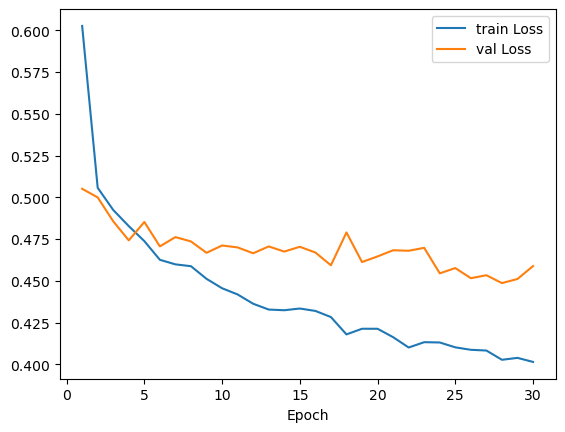

In [17]:
plot_losses_LSTM = {
    'train Loss': best_train_losses_LSTM,
    'val Loss': best_valid_losses_LSTM
}

plot_losses_CNN = {
    'train Loss': best_train_losses_CNN,
    'val Loss': best_valid_losses_CNN
}

epochs_range = range(1, num_epochs + 1)

config_best_model_LSTM = (
        f"width-{best_config_LSTM['width']}-lr-{best_config_LSTM['lr_rate']}"
        f"-dropout-{best_config_LSTM['dropout']}-layers-{best_config_LSTM['num_layers']}"
    )

config_best_model_CNN = (
        f"width-{best_config_CNN['width']}-lr-{best_config_CNN['lr_rate']}"
        f"-dropout-{best_config_CNN['dropout']}-layers-{best_config_CNN['num_layers']}"
    )

utils.plot(epochs_range, plot_losses_LSTM, filename=f'loss_LSTM-{config_best_model_LSTM}.pdf', ylim=None)
utils.plot(epochs_range, plot_losses_CNN, filename=f'loss_CNN-{config_best_model_CNN}.pdf', ylim=None)

In [11]:
print(best_config_LSTM)
print(best_val_corr_LSTM)
print(best_config_CNN)
print(best_val_corr_CNN)

{'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}
tensor(0.6534)
{'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}
tensor(0.5902)
